# PARTE 01 — EDA, Correlações e Documentação
Este bloco reúne: carregamento/validações, estatísticas descritivas, exploração de variáveis numéricas e categóricas, investigação de correlações e comentários dos achados.


# Notebook de EDA: Consumo de café, cafeína e relação com sono e saúde

Este notebook investiga como o consumo de café e cafeína se relaciona com a quantidade e a qualidade do sono, além de outros fatores de saúde. Usaremos o dataset `synthetic_coffee_health_10000(in).csv` e vamos:

- Validar e entender a estrutura dos dados
- Explorar variáveis numéricas e categóricas
- Investigar correlações e relações chave (ex.: Coffee_Intake vs Sleep_Hours)
- Construir modelos simples para quantificar relações
- Documentar achados e exportar artefatos


In [22]:
# Configuração do ambiente e importações
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualização interativa opcional
import plotly
import plotly.express as px

# Opções de exibição
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f"{x:,.3f}")

# Estilo dos gráficos
sns.set_theme(style='whitegrid', context='notebook')

# Pasta de saída para figuras e artefatos
OUT_DIR = 'outputs_eda'
os.makedirs(OUT_DIR, exist_ok=True)

print('Versões:')
print('Python:', sys.version)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('seaborn:', sns.__version__)
print('scipy:', scipy.__version__)
print('statsmodels:', sm.__version__)
print('plotly:', plotly.__version__)


Versões:
Python: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
pandas: 2.3.3
numpy: 2.3.4
seaborn: 0.13.2
scipy: 1.16.3
statsmodels: 0.14.5
plotly: 6.3.1


## Carregamento do dataset e leitura segura
Carregamos o arquivo CSV com `pd.read_csv`, tratando possíveis questões de encoding e tipos. Em seguida validamos os cabeçalhos esperados conforme o dicionário de dados e inspecionamos algumas linhas.


In [23]:
# Caminho do arquivo (nome contém parênteses)
DATA_PATH = '/BETA/cafe/synthetic_coffee_health_10000(in).csv'

# Cabeçalhos esperados (dicionário de dados)
EXPECTED_COLS = [
    'ID','Age','Gender','Country','Coffee_Intake','Caffeine_mg','Sleep_Hours',
    'Sleep_Quality','BMI','Heart_Rate','Stress_Level','Physical_Activity_Hours',
    'Health_Issues','Occupation','Smoking','Alcohol_Consumption'
]

# Leitura segura
read_kwargs = dict(low_memory=False)
try:
    df = pd.read_csv(DATA_PATH, **read_kwargs)
except UnicodeDecodeError:
    df = pd.read_csv(DATA_PATH, encoding='latin-1', **read_kwargs)

print('Dimensões:', df.shape)
print('Colunas:', list(df.columns))

# Validar cabeçalhos
missing = [c for c in EXPECTED_COLS if c not in df.columns]
extra = [c for c in df.columns if c not in EXPECTED_COLS]
print('Colunas ausentes vs esperado:', missing)
print('Colunas extras no arquivo:', extra)

# Amostras aleatórias e primeiras/últimas linhas
display(df.sample(min(5, len(df)), random_state=42))
display(df.head(3))
display(df.tail(3))


Dimensões: (10000, 16)
Colunas: ['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']
Colunas ausentes vs esperado: []
Colunas extras no arquivo: []


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
6252,6253,66,Male,Norway,2.600,245.900,6.700,Good,30.100,76,Low,1.900,Moderate,Service,0,1
4684,4685,22,Female,Mexico,3.100,293.100,7.600,Good,20.400,69,Low,5.000,NaN,Service,0,0
1731,1732,30,Male,Australia,3.900,372.400,6.400,Good,27.500,75,Low,13.800,NaN,Office,0,0
4742,4743,35,Male,Germany,1.000,92.500,5.300,Fair,23.100,71,Medium,2.400,Mild,Service,0,0
4521,4522,47,Male,Italy,1.300,119.000,6.900,Good,28.400,64,Low,9.600,NaN,Office,1,0


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.500,328.100,7.500,Good,24.900,78,Low,14.500,NaN,Other,0,0
1,2,33,Male,Germany,1.000,94.100,6.200,Good,20.000,67,Low,11.000,NaN,Service,0,0
2,3,42,Male,Brazil,5.300,503.700,5.900,Fair,22.700,59,Medium,11.200,Mild,Office,0,0


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
9997,9998,26,Male,China,1.600,153.400,7.100,Good,25.100,66,Low,13.700,NaN,Student,1,1
9998,9999,40,Female,Finland,3.400,327.100,7.000,Good,19.300,80,Low,0.100,NaN,Student,0,0
9999,10000,42,Female,Brazil,2.900,277.500,6.400,Good,28.100,72,Low,9.800,NaN,Student,1,0


## Visão geral: shape, colunas, dtypes, nulos, duplicados
Nesta seção verificamos estrutura, tipos, valores ausentes e duplicados, além do uso de memória.


In [3]:
# Estrutura geral
print('Shape:', df.shape)
print('\nDtypes:')
print(df.dtypes)

print('\nValores ausentes por coluna:')
print(df.isna().sum().sort_values(ascending=False))

print('\nRegistros duplicados:', int(df.duplicated().sum()))

mem_bytes = df.memory_usage(deep=True).sum()
print(f"\nUso de memória (MB): {mem_bytes/1024**2:,.2f}")

print('\nPrimeiras linhas:')
display(df.head())
print('Últimas linhas:')
display(df.tail())


Shape: (10000, 16)

Dtypes:
ID                           int64
Age                          int64
Gender                      object
Country                     object
Coffee_Intake              float64
Caffeine_mg                float64
Sleep_Hours                float64
Sleep_Quality               object
BMI                        float64
Heart_Rate                   int64
Stress_Level                object
Physical_Activity_Hours    float64
Health_Issues               object
Occupation                  object
Smoking                      int64
Alcohol_Consumption          int64
dtype: object

Valores ausentes por coluna:
Health_Issues              5941
ID                            0
Gender                        0
Age                           0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Country                       0
Sleep_Quality                 0
BMI                           0
Stress_Level                  0
Heart_Rate      

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.500,328.100,7.500,Good,24.900,78,Low,14.500,NaN,Other,0,0
1,2,33,Male,Germany,1.000,94.100,6.200,Good,20.000,67,Low,11.000,NaN,Service,0,0
2,3,42,Male,Brazil,5.300,503.700,5.900,Fair,22.700,59,Medium,11.200,Mild,Office,0,0
3,4,53,Male,Germany,2.600,249.200,7.300,Good,24.700,71,Low,6.600,Mild,Other,0,0
4,5,32,Female,Spain,3.100,298.000,5.300,Fair,24.100,76,Medium,8.500,Mild,Student,0,1


Últimas linhas:


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
9995,9996,50,Female,Japan,2.100,199.800,6.000,Fair,30.500,50,Medium,10.100,Moderate,Healthcare,0,1
9996,9997,18,Female,UK,3.400,319.200,5.800,Fair,19.100,71,Medium,11.600,Mild,Service,0,0
9997,9998,26,Male,China,1.600,153.400,7.100,Good,25.100,66,Low,13.700,NaN,Student,1,1
9998,9999,40,Female,Finland,3.400,327.100,7.000,Good,19.300,80,Low,0.100,NaN,Student,0,0
9999,10000,42,Female,Brazil,2.900,277.500,6.400,Good,28.100,72,Low,9.800,NaN,Student,1,0


## Padronização de tipos e limpeza inicial
Transformamos tipos conforme dicionário e aplicamos clipping para garantir faixas plausíveis.


In [25]:
# Cópia de trabalho
df0 = df.copy()

# Conversões de tipo
cat_cols = ['Gender','Country','Sleep_Quality','Stress_Level','Health_Issues','Occupation']
bool_cols = ['Smoking','Alcohol_Consumption']

for c in cat_cols:
    if c in df0.columns:
        df0[c] = df0[c].astype('string').str.strip().astype('category')
for c in bool_cols:
    if c in df0.columns:
        # suporta 0/1, True/False, '0'/'1'
        df0[c] = df0[c].replace({'0':0,'1':1}).astype('float').astype('Int64').astype('boolean')
if 'ID' in df0.columns:
    df0['ID'] = pd.to_numeric(df0['ID'], errors='coerce').astype('Int64')

# Clipping de faixas plausíveis conforme dicionário
ranges = {
    'Age': (18, 80),
    'Coffee_Intake': (0, 10),
    'Caffeine_mg': (0, 10*95),
    'Sleep_Hours': (3, 10),
    'BMI': (15, 40),
    'Heart_Rate': (50, 110),
    'Physical_Activity_Hours': (0, 15)
}
for col, (lo, hi) in ranges.items():
    if col in df0.columns:
        df0[col] = pd.to_numeric(df0[col], errors='coerce')
        before_out = ((df0[col] < lo) | (df0[col] > hi)).sum()
        df0[col] = df0[col].clip(lower=lo, upper=hi)
        after_out = ((df0[col] < lo) | (df0[col] > hi)).sum()
        if before_out > 0:
            print(f'{col}: {before_out} valores fora da faixa foram clipados.')

# Remover duplicados por ID se existir ID único
if 'ID' in df0.columns:
    dup_id = df0.duplicated(subset=['ID']).sum()
    if dup_id:
        print('Registros duplicados por ID removidos:', int(dup_id))
        df0 = df0.drop_duplicates(subset=['ID'])

print('Dimensões após limpeza:', df0.shape)


Dimensões após limpeza: (10000, 16)


## Estatísticas descritivas e percentis
Geramos estatísticas para variáveis numéricas e categóricas, além de assimetria (skewness) e curtose.


In [5]:
# Estatísticas para numéricas
num_cols = [c for c in df0.select_dtypes(include=[np.number]).columns if c not in ['ID']]
desc_num = df0[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T

desc_num['skew'] = df0[num_cols].skew()
desc_num['kurtosis'] = df0[num_cols].kurtosis()

display(desc_num)

# Estatísticas para categóricas
cat_cols_present = [c for c in cat_cols if c in df0.columns]
if cat_cols_present:
    desc_cat = df0[cat_cols_present].describe(include='category').T
    display(desc_cat)
else:
    print('Sem colunas categóricas para descrever.')


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew,kurtosis
Age,"10,000.000",34.949,11.161,18.000,18.000,18.000,26.000,34.000,43.000,54.000,62.010,80.000,0.362,-0.346
Coffee_Intake,"10,000.000",2.509,1.450,0.000,0.000,0.000,1.500,2.500,3.500,5.000,6.100,8.200,0.263,-0.277
Caffeine_mg,"10,000.000",238.411,137.749,0.000,0.000,0.000,138.750,235.400,332.025,474.005,578.603,780.300,0.263,-0.276
Sleep_Hours,"10,000.000",6.636,1.222,3.000,3.800,4.600,5.800,6.600,7.500,8.600,9.500,10.000,-0.018,-0.138
BMI,"10,000.000",23.987,3.906,15.000,15.000,17.400,21.300,24.000,26.600,30.300,33.100,38.200,0.048,-0.165
Heart_Rate,"10,000.000",70.618,9.823,50.000,50.000,54.000,64.000,71.000,77.000,87.000,93.000,109.000,0.104,-0.257
Physical_Activity_Hours,"10,000.000",7.487,4.315,0.000,0.200,0.800,3.700,7.500,11.200,14.300,14.900,15.000,0.004,-1.198


,count,unique,top,freq
Gender,10000,3,Female,5001
Country,10000,20,Canada,543
Sleep_Quality,10000,4,Good,5637
Stress_Level,10000,3,Low,6989
Health_Issues,4059,3,Mild,3579
Occupation,10000,5,Office,2073


## Exploração de variáveis numéricas: histogramas, KDE e boxplots
Avaliamos distribuições e possíveis caudas/assimetria para as principais variáveis numéricas.


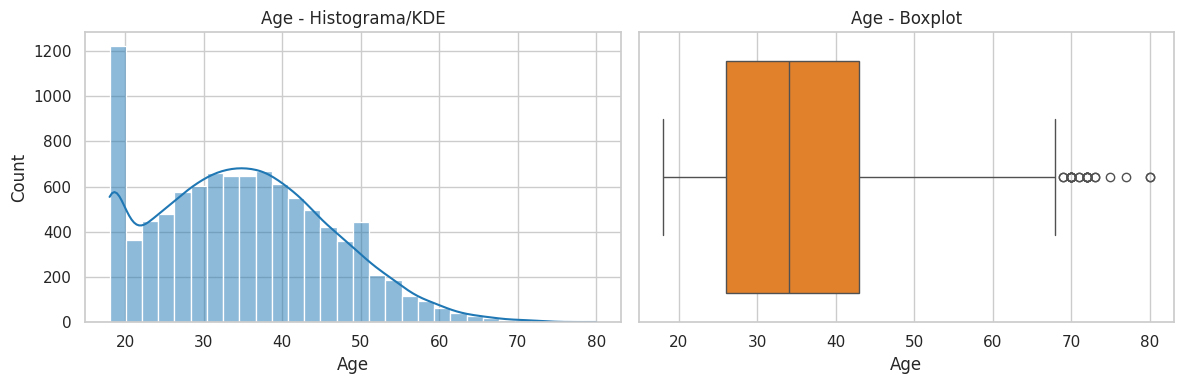

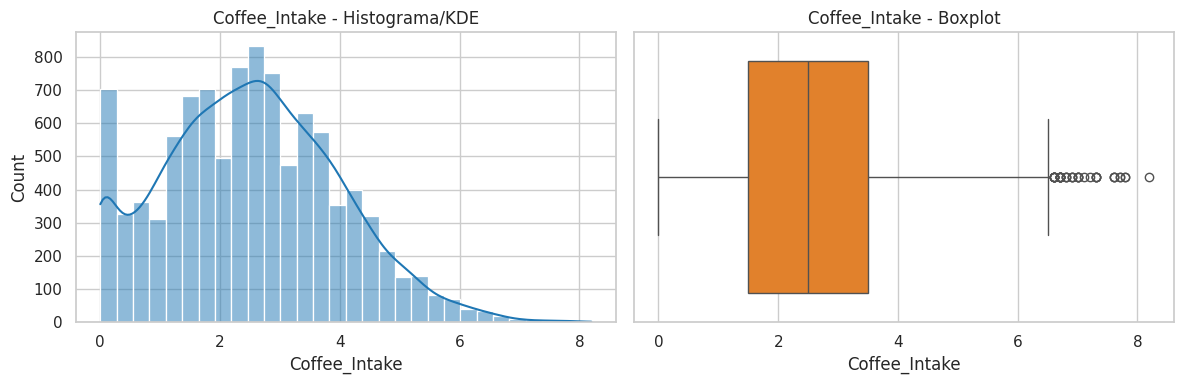

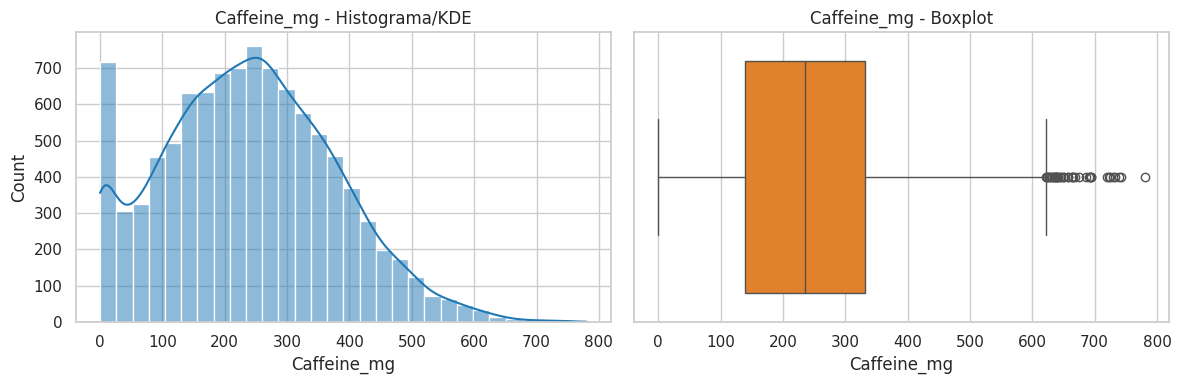

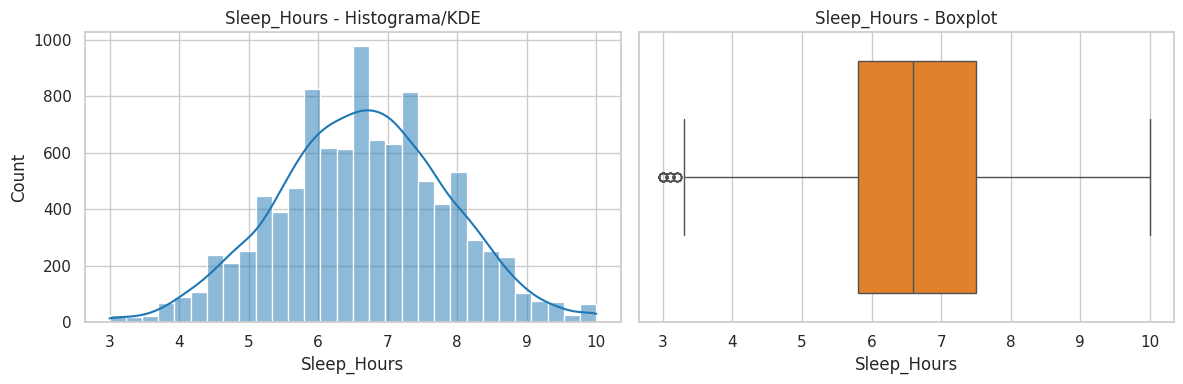

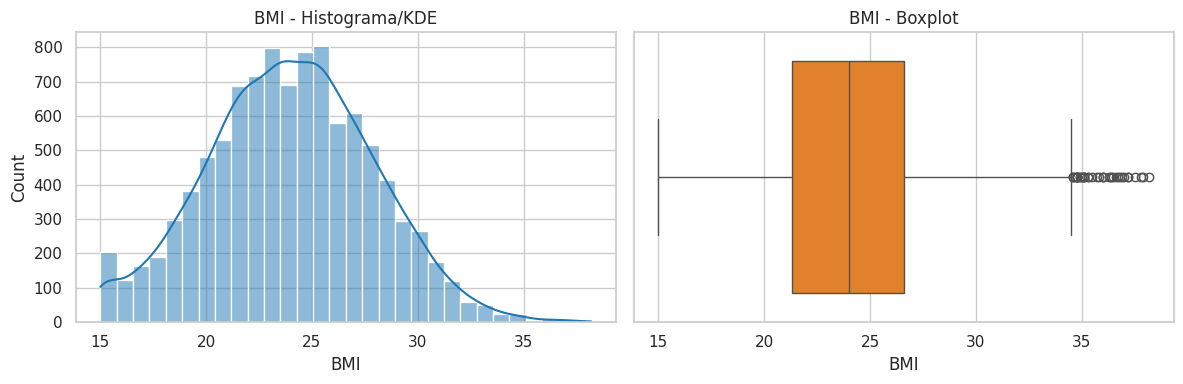

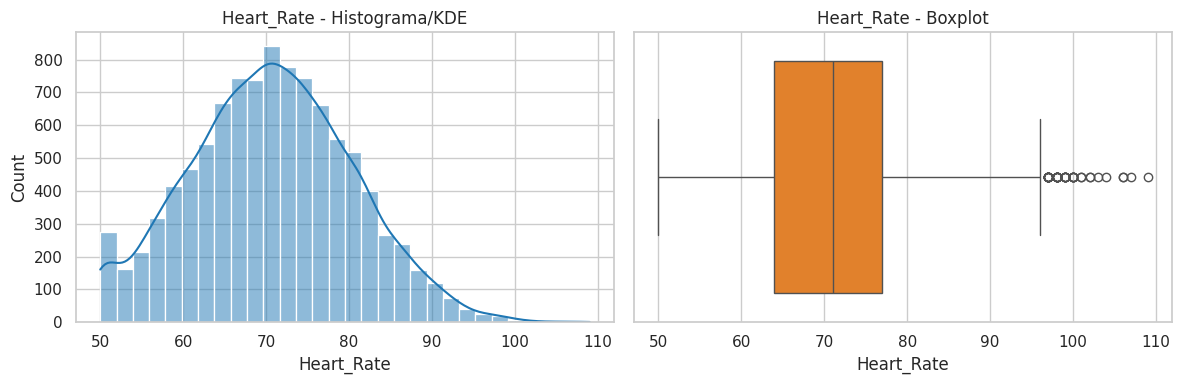

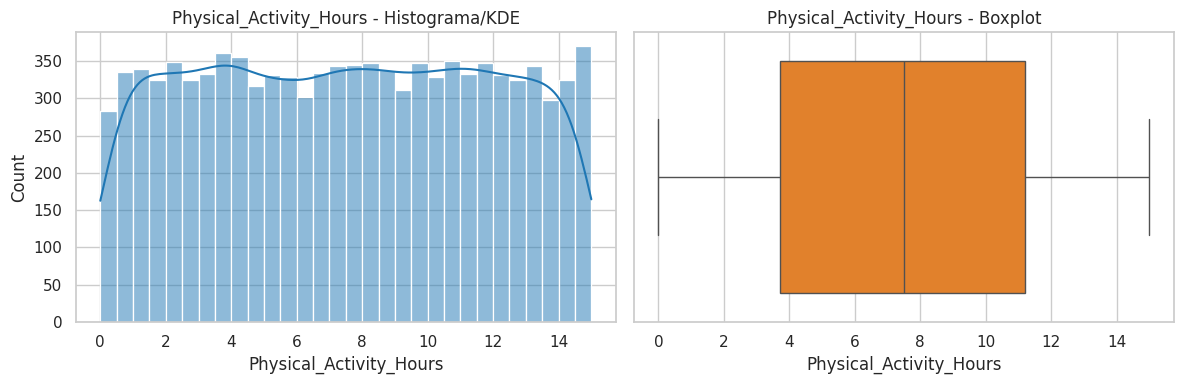

In [6]:
num_to_plot = [
    'Age','Coffee_Intake','Caffeine_mg','Sleep_Hours','BMI','Heart_Rate','Physical_Activity_Hours'
]
num_to_plot = [c for c in num_to_plot if c in df0.columns]

for col in num_to_plot:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(df0[col].dropna(), kde=True, ax=ax[0], bins=30, color='#1f77b4')
    ax[0].set_title(f'{col} - Histograma/KDE')
    sns.boxplot(x=df0[col], ax=ax[1], color='#ff7f0e')
    ax[1].set_title(f'{col} - Boxplot')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'dist_{col}.png'), dpi=160, bbox_inches='tight')
    plt.show()


## Exploração de variáveis categóricas: contagens e proporções
Frequências absolutas e relativas para as principais variáveis categóricas.



Gender - contagens:


Gender
Female    5001
Male      4773
Other      226
Name: count, dtype: int64

Gender - proporções:


Gender
Female    50.01%
Male      47.73%
Other      2.26%
Name: proportion, dtype: object

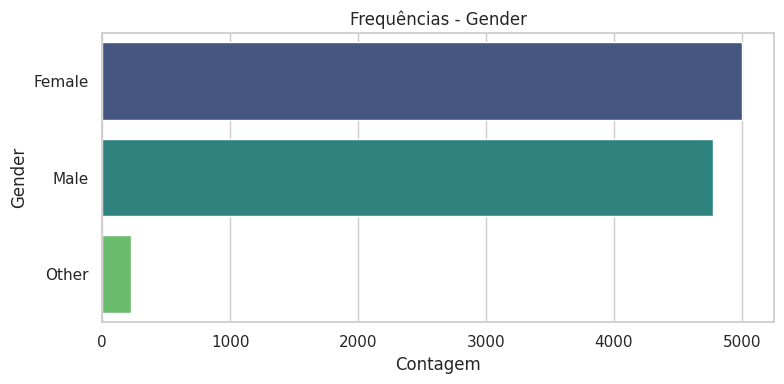


Country - contagens:


Country
Canada         543
India          524
Norway         523
China          521
UK             519
Sweden         513
South Korea    512
Finland        510
Italy          509
Switzerland    500
France         499
Australia      497
Germany        497
Belgium        497
Netherlands    494
Spain          486
Mexico         483
Japan          469
Brazil         456
USA            448
Name: count, dtype: int64

Country - proporções:


Country
Canada         5.43%
India          5.24%
Norway         5.23%
China          5.21%
UK             5.19%
Sweden         5.13%
South Korea    5.12%
Finland         5.1%
Italy          5.09%
Switzerland     5.0%
France         4.99%
Australia      4.97%
Germany        4.97%
Belgium        4.97%
Netherlands    4.94%
Spain          4.86%
Mexico         4.83%
Japan          4.69%
Brazil         4.56%
USA            4.48%
Name: proportion, dtype: object

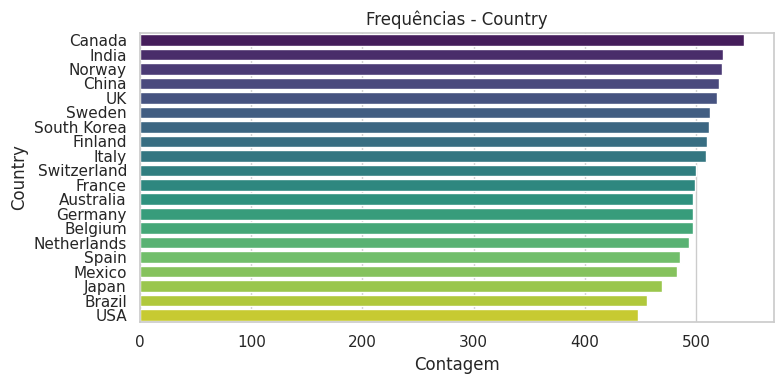


Sleep_Quality - contagens:


Sleep_Quality
Good         5637
Fair         2050
Excellent    1352
Poor          961
Name: count, dtype: int64

Sleep_Quality - proporções:


Sleep_Quality
Good         56.37%
Fair          20.5%
Excellent    13.52%
Poor          9.61%
Name: proportion, dtype: object

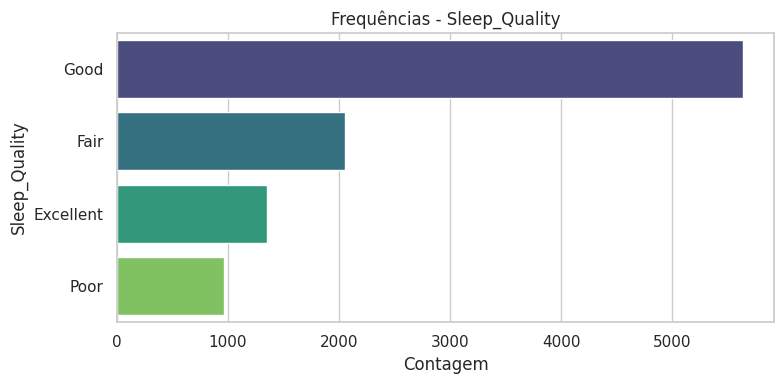


Stress_Level - contagens:


Stress_Level
Low       6989
Medium    2050
High       961
Name: count, dtype: int64

Stress_Level - proporções:


Stress_Level
Low       69.89%
Medium     20.5%
High       9.61%
Name: proportion, dtype: object

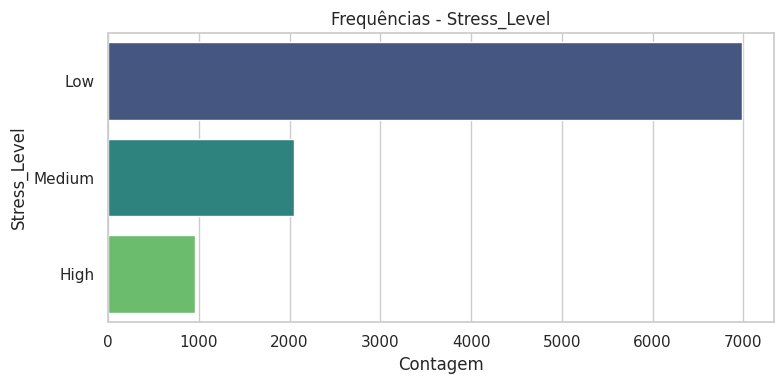


Health_Issues - contagens:


Health_Issues
<NA>        5941
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

Health_Issues - proporções:


Health_Issues
<NA>        59.41%
Mild        35.79%
Moderate     4.63%
Severe       0.17%
Name: proportion, dtype: object

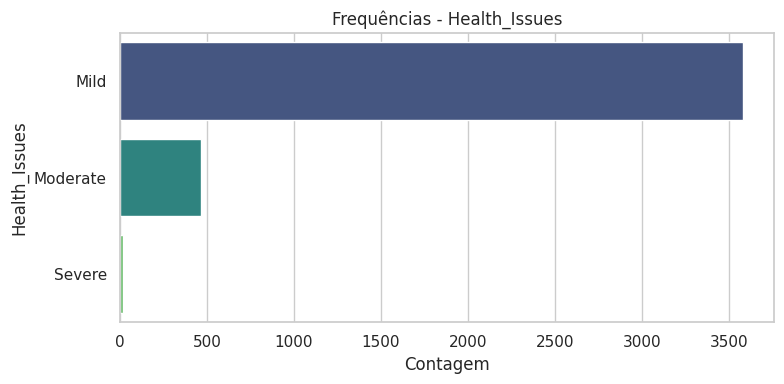


Occupation - contagens:


Occupation
Office        2073
Other         2038
Student       1968
Healthcare    1964
Service       1957
Name: count, dtype: int64

Occupation - proporções:


Occupation
Office        20.73%
Other         20.38%
Student       19.68%
Healthcare    19.64%
Service       19.57%
Name: proportion, dtype: object

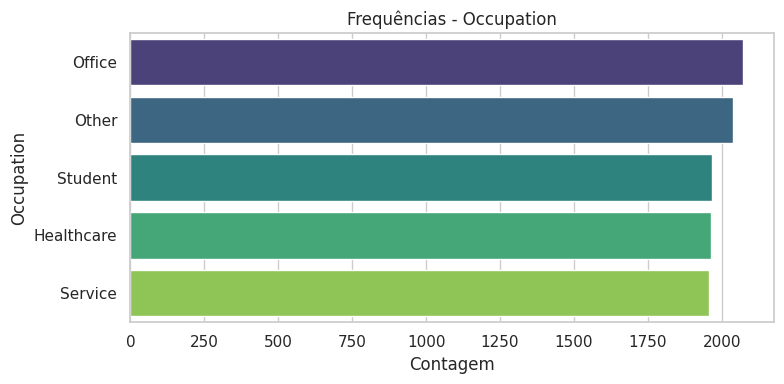


Smoking - contagens:


Smoking
False    7996
True     2004
Name: count, dtype: Int64

Smoking - proporções:


Smoking
False    79.96%
True     20.04%
Name: proportion, dtype: object

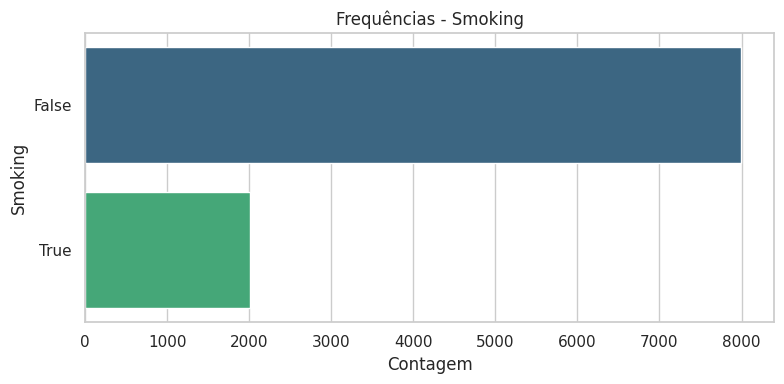


Alcohol_Consumption - contagens:


Alcohol_Consumption
False    6993
True     3007
Name: count, dtype: Int64

Alcohol_Consumption - proporções:


Alcohol_Consumption
False    69.93%
True     30.07%
Name: proportion, dtype: object

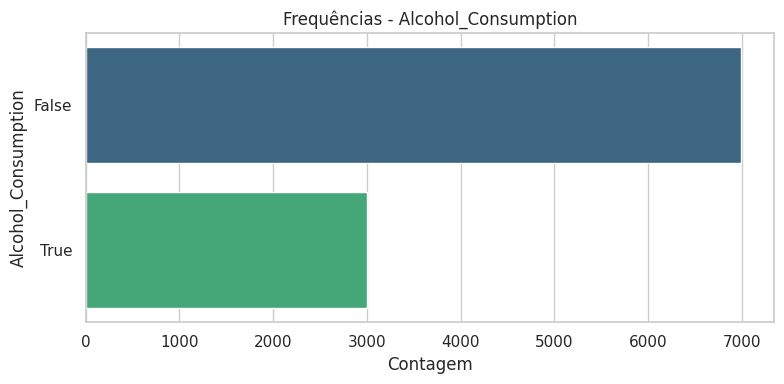

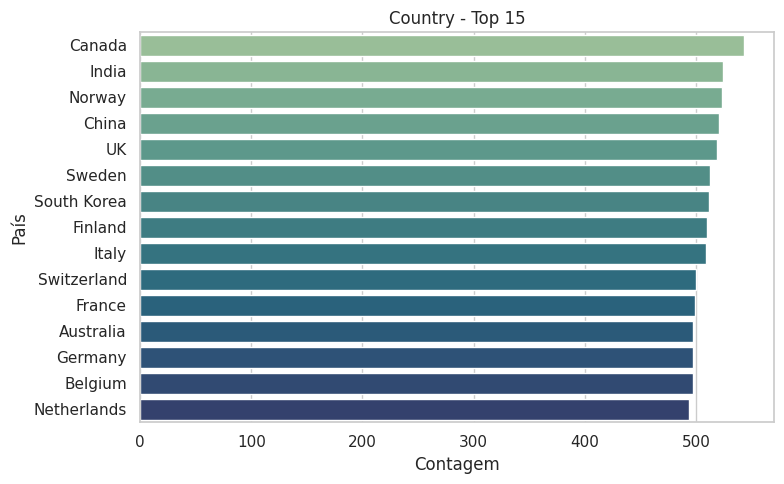

In [7]:
cat_to_plot = ['Gender','Country','Sleep_Quality','Stress_Level','Health_Issues','Occupation','Smoking','Alcohol_Consumption']
cat_to_plot = [c for c in cat_to_plot if c in df0.columns]

for col in cat_to_plot:
    vc = df0[col].value_counts(dropna=False)
    vcn = df0[col].value_counts(dropna=False, normalize=True)
    print(f"\n{col} - contagens:")
    display(vc)
    print(f"{col} - proporções:")
    display((vcn*100).round(2).astype(str) + '%')

    fig, ax = plt.subplots(figsize=(8, 4))
    order = vc.index
    sns.barplot(x=vc.values, y=order.astype(str), ax=ax, palette='viridis')
    ax.set_title(f'Frequências - {col}')
    ax.set_xlabel('Contagem')
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'bar_{col}.png'), dpi=160, bbox_inches='tight')
    plt.show()

# País: exibir top 15 caso muitas categorias
if 'Country' in df0.columns:
    vc_cty = df0['Country'].value_counts()
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(x=vc_cty.head(15).values, y=vc_cty.head(15).index.astype(str), ax=ax, palette='crest')
    ax.set_title('Country - Top 15')
    ax.set_xlabel('Contagem')
    ax.set_ylabel('País')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'bar_Country_top15.png'), dpi=160, bbox_inches='tight')
    plt.show()


## Outliers: detecção via IQR e inspeção
Identificamos outliers por coluna usando a regra de 1.5*IQR e quantificamos a proporção de casos.


,col,Q1,Q3,IQR,lower,upper,outliers_%
5,Heart_Rate,64.000,77.000,13.000,44.500,96.500,0.500
4,BMI,21.300,26.600,5.300,13.350,34.550,0.400
1,Coffee_Intake,1.500,3.500,2.000,-1.500,6.500,0.390
2,Caffeine_mg,138.750,332.025,193.275,-151.162,621.938,0.390
3,Sleep_Hours,5.800,7.500,1.700,3.250,10.050,0.260
0,Age,26.000,43.000,17.000,0.500,68.500,0.250
6,Physical_Activity_Hours,3.700,11.200,7.500,-7.550,22.450,0.000


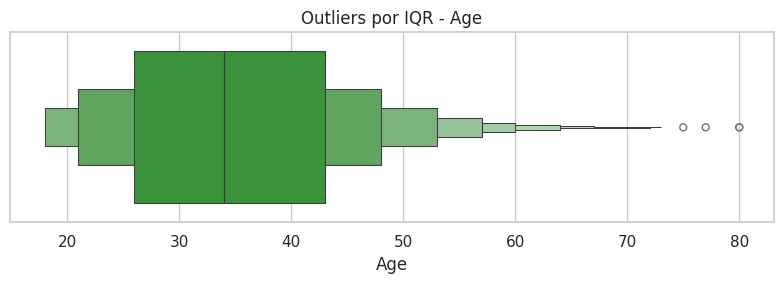

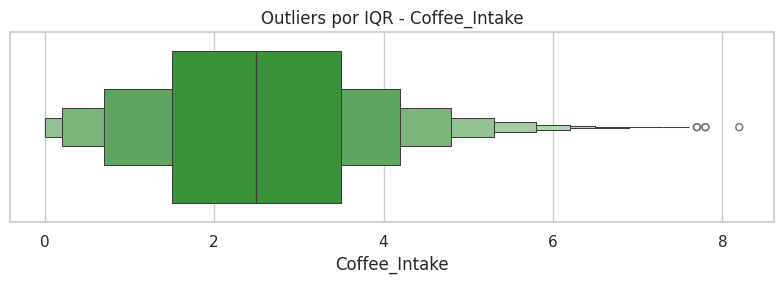

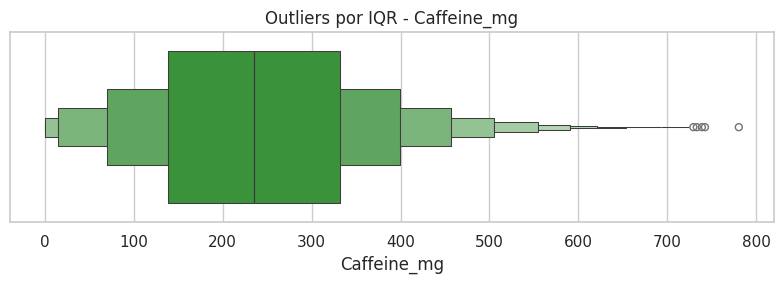

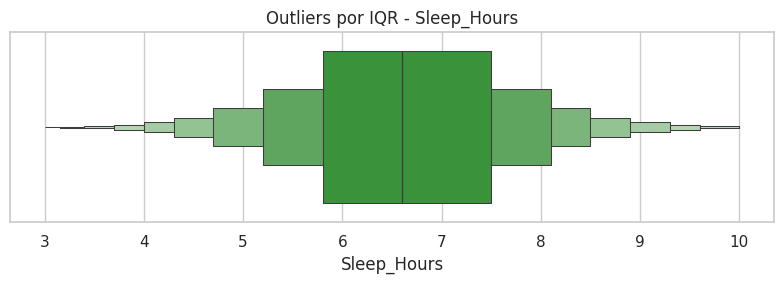

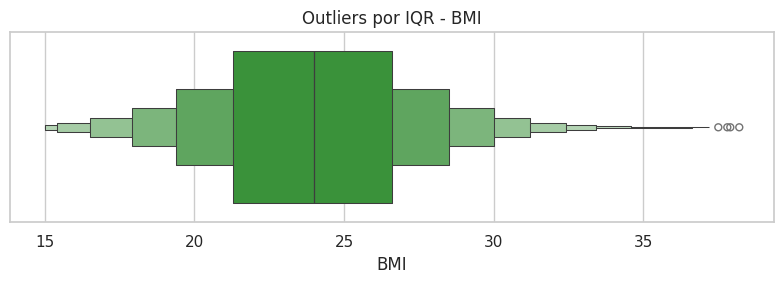

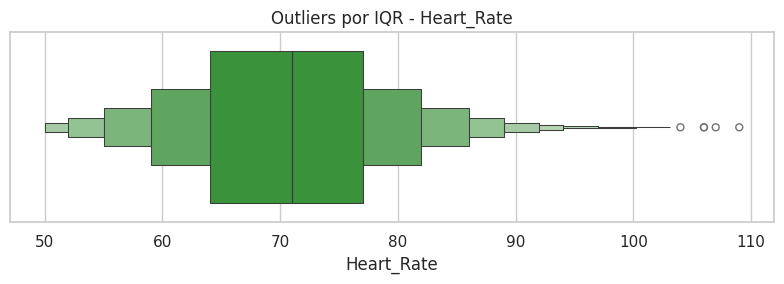

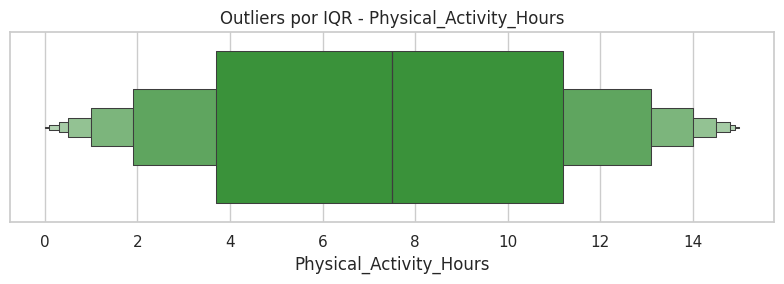

In [8]:
# Detecção de outliers por IQR
num_cols_iqr = [c for c in num_cols if c in df0.columns]

iqr_summary = []
for c in num_cols_iqr:
    q1 = df0[c].quantile(0.25)
    q3 = df0[c].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    mask = (df0[c] < lower) | (df0[c] > upper)
    out_pct = mask.mean()*100
    iqr_summary.append({'col': c, 'Q1': q1, 'Q3': q3, 'IQR': iqr, 'lower': lower, 'upper': upper, 'outliers_%': out_pct})

summary_iqr = pd.DataFrame(iqr_summary).sort_values('outliers_%', ascending=False)
display(summary_iqr)

# Visualização com boxenplot
for c in num_cols_iqr:
    plt.figure(figsize=(8,3))
    sns.boxenplot(x=df0[c], color='#2ca02c')
    plt.title(f'Outliers por IQR - {c}')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'outliers_{c}.png'), dpi=160, bbox_inches='tight')
    plt.show()


## Correlações numéricas e heatmap
Avaliamos correlações de Pearson e Spearman entre variáveis numéricas e visualizamos com heatmap.

A correlação de Pearson é definida por:

$r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}$


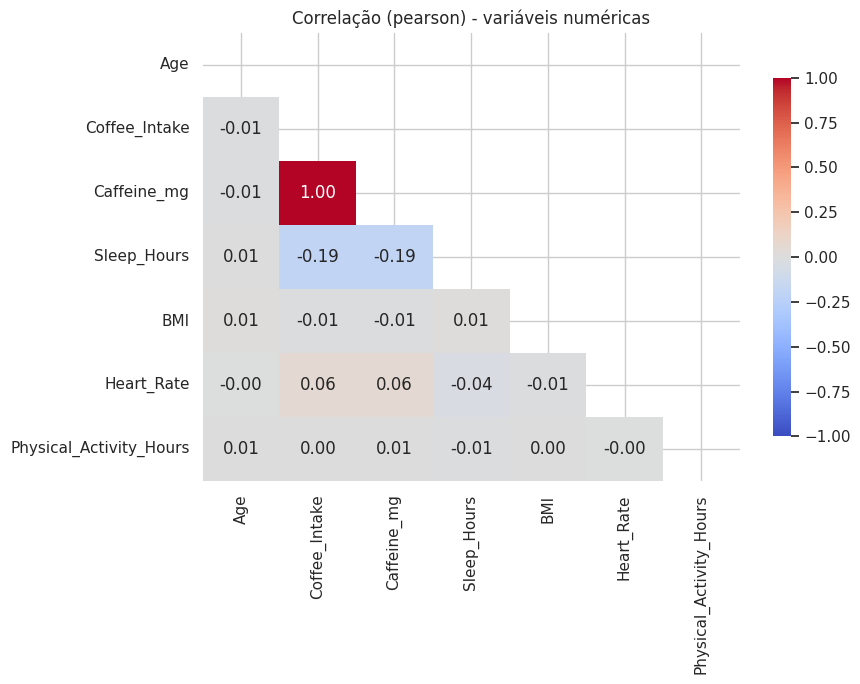

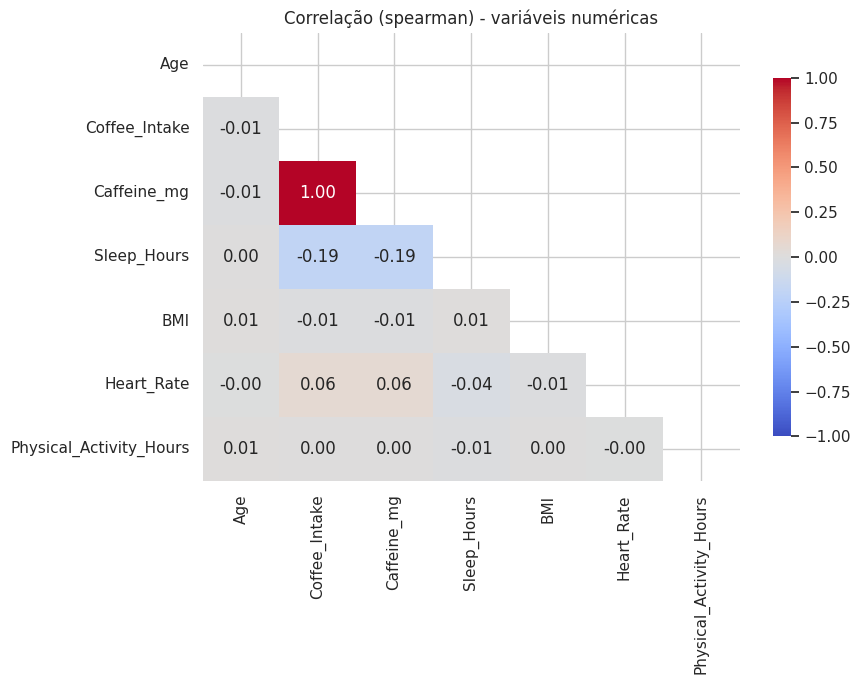

Pares com |r| >= 0.5 (Pearson):
Coffee_Intake ~ Caffeine_mg: r=1.000


In [9]:
corr_df = df0[num_cols].corr(method='pearson')
corr_spear = df0[num_cols].corr(method='spearman')

for name, mat in [('pearson', corr_df), ('spearman', corr_spear)]:
    plt.figure(figsize=(9,7))
    mask = np.triu(np.ones_like(mat, dtype=bool))
    sns.heatmap(mat, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, vmin=-1, vmax=1, cbar_kws={'shrink':.8})
    plt.title(f'Correlação ({name}) - variáveis numéricas')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'heatmap_corr_{name}.png'), dpi=160, bbox_inches='tight')
    plt.show()

# Pares com |r| alto (ex.: > 0.5) - Pearson
thr = 0.5
pairs = []
for i, a in enumerate(corr_df.columns):
    for j, b in enumerate(corr_df.columns):
        if j <= i: continue
        r = corr_df.loc[a, b]
        if abs(r) >= thr:
            pairs.append((a, b, r))

pairs = sorted(pairs, key=lambda x: -abs(x[2]))
print('Pares com |r| >= 0.5 (Pearson):')
for a,b,r in pairs:
    print(f'{a} ~ {b}: r={r:.3f}')


## Café vs horas de sono: dispersão, regressão e correlação
Vamos avaliar a relação entre Coffee_Intake e Sleep_Hours por meio de gráficos e testes de correlação, além de um modelo OLS simples.


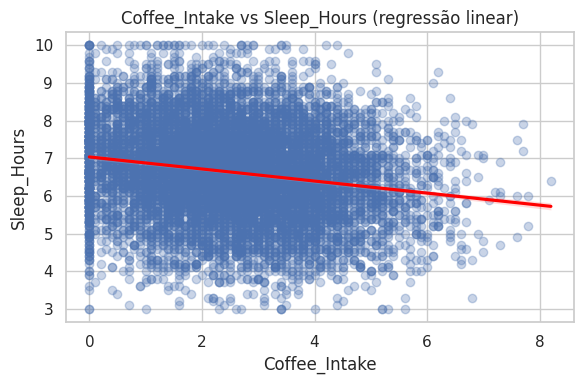

Pearson r=-0.190, p=3.53e-82 | Spearman r=-0.190, p=5.68e-82


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sleep_Hours   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     375.6
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           3.53e-82
Time:                        07:09:04   Log-Likelihood:                -16010.
No. Observations:               10000   AIC:                         3.202e+04
Df Residuals:                    9998   BIC:                         3.204e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.0386      0.024    293.549      0.000       6.992       7.086
Coffee_Intake    -0.1603      0.008    -19.381      0.000      -0.177      -0.144
==============================================================================
Omnibus:                        5.502   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.280
Skew:                          -0.032   Prob(JB):                       0.0714
Kurtosis:                       2.908   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

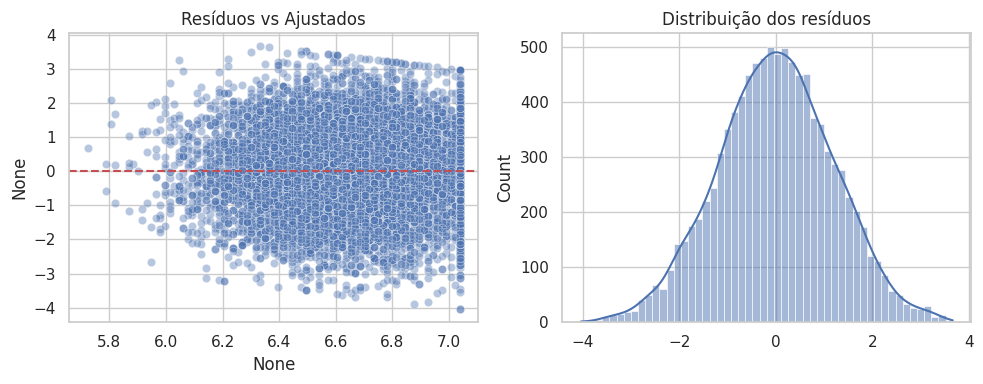

In [10]:
xcol, ycol = 'Coffee_Intake', 'Sleep_Hours'
if all(c in df0.columns for c in [xcol, ycol]):
    plt.figure(figsize=(6,4))
    sns.regplot(data=df0, x=xcol, y=ycol, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f'{xcol} vs {ycol} (regressão linear)')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'scatter_{xcol}_vs_{ycol}.png'), dpi=160, bbox_inches='tight')
    plt.show()

    # Correlações
    valid = df0[[xcol,ycol]].dropna()
    r_p, p_p = stats.pearsonr(valid[xcol], valid[ycol])
    r_s, p_s = stats.spearmanr(valid[xcol], valid[ycol])
    print(f'Pearson r={r_p:.3f}, p={p_p:.3g} | Spearman r={r_s:.3f}, p={p_s:.3g}')

    # Regressão simples (OLS)
    model = smf.ols(f'{ycol} ~ {xcol}', data=df0).fit()
    display(model.summary())

    # Resíduos
    resid = model.resid
    fitted = model.fittedvalues
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(x=fitted, y=resid, ax=ax[0], alpha=0.4)
    ax[0].axhline(0, color='r', ls='--')
    ax[0].set_title('Resíduos vs Ajustados')
    sns.histplot(resid, kde=True, ax=ax[1])
    ax[1].set_title('Distribuição dos resíduos')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'resid_{xcol}_vs_{ycol}.png'), dpi=160, bbox_inches='tight')
    plt.show()
else:
    print('Colunas necessárias não encontradas.')


## Café e cafeína vs estresse e qualidade do sono: comparações por grupos
Comparamos distribuições de consumo por níveis de `Stress_Level` e `Sleep_Quality` e testamos diferenças entre grupos.


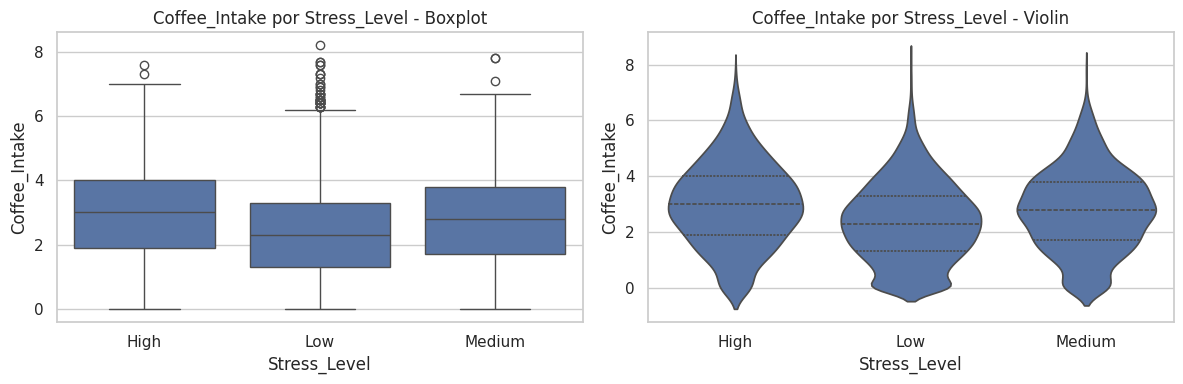

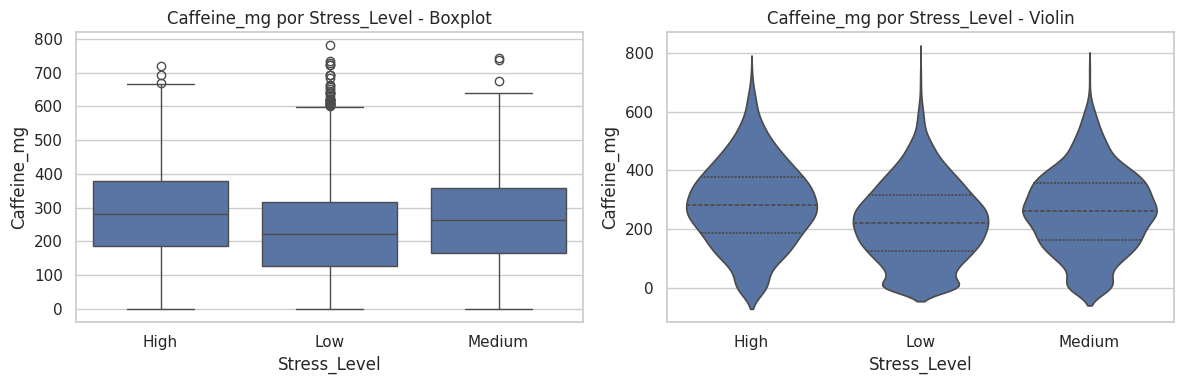

Coffee_Intake ~ Stress_Level | ANOVA F=117.087, p=5.45e-51 | Kruskal H=221.664, p=7.35e-49
Caffeine_mg ~ Stress_Level | ANOVA F=117.504, p=3.62e-51 | Kruskal H=221.933, p=6.43e-49
Coffee_Intake ~ Stress_Level | eta^2=0.023
Caffeine_mg ~ Stress_Level | eta^2=0.023


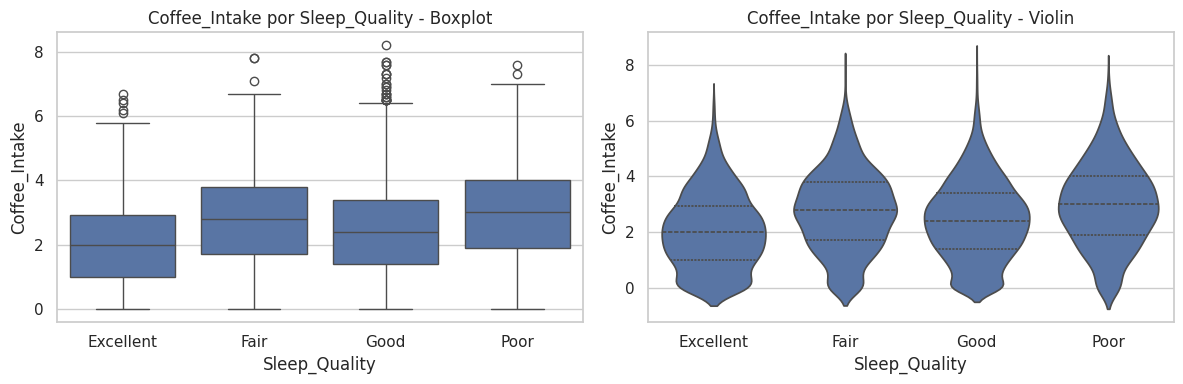

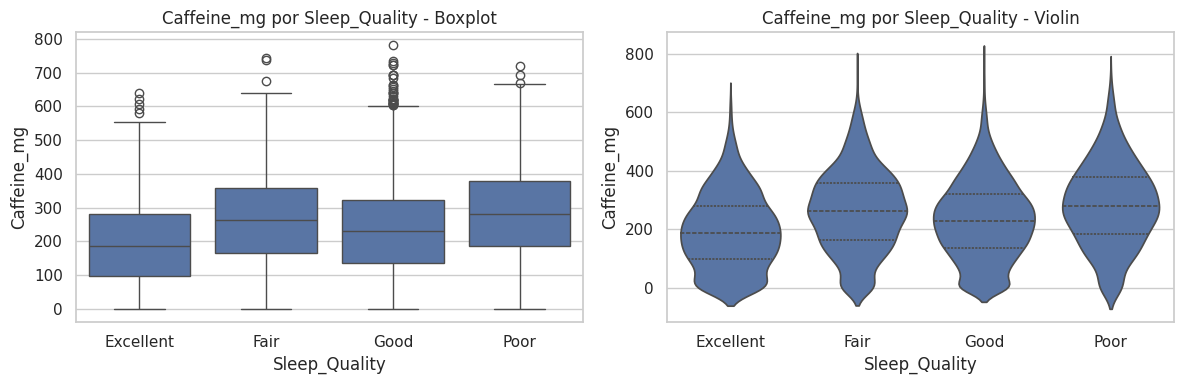

Coffee_Intake ~ Sleep_Quality | ANOVA F=106.921, p=3.9e-68 | Kruskal H=304.377, p=1.12e-65
Caffeine_mg ~ Sleep_Quality | ANOVA F=107.221, p=2.52e-68 | Kruskal H=304.741, p=9.37e-66
Coffee_Intake ~ Sleep_Quality | eta^2=0.031
Caffeine_mg ~ Sleep_Quality | eta^2=0.031
Spearman(Coffee_Intake, Sleep_Quality_ordinal) r=-0.174, p=1.96e-68
Spearman(Caffeine_mg, Sleep_Quality_ordinal) r=-0.174, p=1.59e-68


In [11]:
grp_vars = ['Stress_Level','Sleep_Quality']
metrics = ['Coffee_Intake','Caffeine_mg']

for g in grp_vars:
    if g in df0.columns:
        for m in metrics:
            if m in df0.columns:
                fig, ax = plt.subplots(1,2, figsize=(12,4))
                sns.boxplot(data=df0, x=g, y=m, ax=ax[0])
                ax[0].set_title(f'{m} por {g} - Boxplot')
                sns.violinplot(data=df0, x=g, y=m, ax=ax[1], inner='quartile')
                ax[1].set_title(f'{m} por {g} - Violin')
                plt.tight_layout()
                plt.savefig(os.path.join(OUT_DIR, f'{m}_by_{g}.png'), dpi=160, bbox_inches='tight')
                plt.show()

        # Testes ANOVA/Kruskal
        for m in metrics:
            if m in df0.columns:
                groups = [v.dropna() for _, v in df0.groupby(g)[m]]
                if len(groups) >= 2 and all(len(x) > 2 for x in groups):
                    # Normalidade aproximada? se não, Kruskal
                    stat_f, p_f = stats.f_oneway(*groups)
                    stat_k, p_k = stats.kruskal(*groups)
                    print(f"{m} ~ {g} | ANOVA F={stat_f:.3f}, p={p_f:.3g} | Kruskal H={stat_k:.3f}, p={p_k:.3g}")

        # Tamanho de efeito (eta-quadrado) para ANOVA de uma via
        for m in metrics:
            if m in df0.columns:
                sub = df0[[g, m]].dropna()
                if sub[g].nunique() > 1:
                    grand_mean = sub[m].mean()
                    ss_between = sub.groupby(g)[m].apply(lambda x: len(x)*(x.mean()-grand_mean)**2).sum()
                    ss_total = ((sub[m]-grand_mean)**2).sum()
                    eta2 = ss_between/ss_total if ss_total > 0 else np.nan
                    print(f"{m} ~ {g} | eta^2={eta2:.3f}")

# Tratar Sleep_Quality como ordinal (ordem suposta): Poor < Fair < Good < Excellent
if 'Sleep_Quality' in df0.columns:
    ord_map = {'Poor':1,'Fair':2,'Good':3,'Excellent':4}
    sq_ord = df0['Sleep_Quality'].astype('string').map(ord_map)
    if 'Coffee_Intake' in df0.columns:
        r_s, p_s = stats.spearmanr(df0['Coffee_Intake'], sq_ord, nan_policy='omit')
        print(f'Spearman(Coffee_Intake, Sleep_Quality_ordinal) r={r_s:.3f}, p={p_s:.3g}')
    if 'Caffeine_mg' in df0.columns:
        r_s, p_s = stats.spearmanr(df0['Caffeine_mg'], sq_ord, nan_policy='omit')
        print(f'Spearman(Caffeine_mg, Sleep_Quality_ordinal) r={r_s:.3f}, p={p_s:.3g}')


## Efeitos conjuntos: regressão linear múltipla para Sleep_Hours
Estimamos um modelo OLS para `Sleep_Hours` com múltiplos preditores e avaliamos multicolinearidade (VIF) e diagnósticos dos resíduos.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sleep_Hours   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     769.8
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:09:08   Log-Likelihood:                -1982.6
No. Observations:                4059   AIC:                             4043.
Df Residuals:                    4020   BIC:                             4289.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.5344      0.057     79.077      0.000       4.422       4.647
C(Gender)[T.Male]                0.0033      0.013      0.259      0.795      -0.021       0.028
C(Gender)[T.Other]              -0.0209      0.042     -0.496      0.620      -0.104       0.062
C(Stress_Level)[T.Low]           4.0515      0.034    119.764      0.000       3.985       4.118
C(Stress_Level)[T.Medium]        0.5362      0.012     46.413      0.000       0.514       0.559
C(Sleep_Quality)[T.Fair]         0.5362      0.012     46.413      0.000       0.514       0.559
C(Sleep_Quality)[T.Good]        -1.6369      0.030    -54.322      0.000      -1.696      -1.578
C(Sleep_Quality)[T.Poor]        -0.0533      0.024     -2.253      0.024      -0.100      -0.007
C(Health_Issues)[T.Moderate]     0.0020      0.023      0.086      0.931      -0.044       0.048
C(Health_Issues)[T.Severe]       0.0036      0.100      0.037      0.971      -0.192       0.200
C(Occupation)[T.Office]          0.0077      0.020      0.388      0.698      -0.031       0.046
C(Occupation)[T.Other]          -0.0205      0.020     -1.035      0.301      -0.059       0.018
C(Occupation)[T.Service]        -0.0084      0.020     -0.426      0.670      -0.047       0.030
C(Occupation)[T.Student]         0.0135      0.020      0.673      0.501      -0.026       0.053
C(Country)[T.Belgium]           -0.0001      0.039     -0.004      0.997      -0.077       0.076
C(Country)[T.Brazil]             0.0024      0.040      0.061      0.951      -0.076       0.081
C(Country)[T.Canada]            -0.0659      0.039     -1.689      0.091      -0.142       0.011
C(Country)[T.China]             -0.0578      0.038     -1.518      0.129      -0.133       0.017
C(Country)[T.Finland]           -0.0494      0.040     -1.242      0.214      -0.127       0.029
C(Country)[T.France]            -0.0069      0.041     -0.169      0.866      -0.087       0.073
C(Country)[T.Germany]           -0.0438      0.039     -1.112      0.266      -0.121       0.033
C(Country)[T.India]             -0.0120      0.038     -0.314      0.754      -0.087       0.063
C(Country)[T.Italy]             -0.0005      0.040     -0.012      0.991      -0.080       0.079
C(Country)[T.Japan]             -0.0152      0.041     -0.373      0.709      -0.095       0.064
C(Country)[T.Mexico]            -0.0056      0.041     -0.136      0.892      -0.086       0.074
C(Country)[T.Netherlands]       -0.0049      0.039     -0.124      0.901      -0.082       0.072
C(Country)[T.Norway]            -0.0462      0.039     -1.172      0.241      -0.124       0.031
C(Country)[T.South Korea]       -0.0420      0.039     -1.077      0.282      -0.118       0.034
C(Country)[T.Spain]             -0.0205      0.038     -0.536      0.592    

const                       107.523
Coffee_Intake             2,711.561
Caffeine_mg               2,711.649
Age                           1.010
BMI                           1.010
Heart_Rate                    1.004
Physical_Activity_Hours       1.002
Smoking                       1.002
Alcohol_Consumption           1.001
Name: VIF, dtype: float64

Breusch-Pagan: {'Lagrange multiplier statistic': np.float64(465.12333947025195), 'p-value': np.float64(8.235991159761044e-74), 'f-value': np.float64(13.691386190628856), 'f p-value': np.float64(3.494404466768324e-80)}


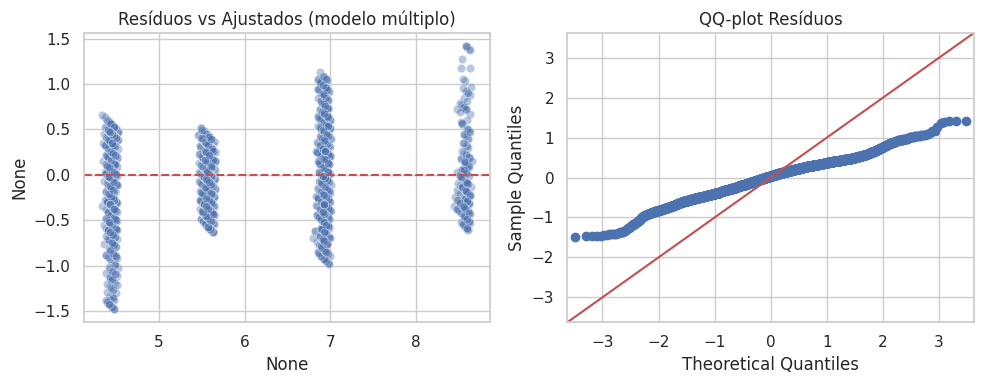

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# Fórmula com variáveis numéricas e fatores (C())
formula = (
    'Sleep_Hours ~ Coffee_Intake + Caffeine_mg + Age + BMI + Heart_Rate + '
    'Physical_Activity_Hours + Smoking + Alcohol_Consumption + '
    'C(Gender) + C(Stress_Level) + C(Sleep_Quality) + C(Health_Issues) + C(Occupation) + C(Country)'
)

# Ajuste do modelo
sub_cols = ['Sleep_Hours','Coffee_Intake','Caffeine_mg','Age','BMI','Heart_Rate','Physical_Activity_Hours','Smoking','Alcohol_Consumption','Gender','Stress_Level','Sleep_Quality','Health_Issues','Occupation','Country']
sub = df0[sub_cols].dropna().copy()

# Corrigir dtypes booleanos para inteiros (patsy/statsmodels não lida com BooleanDtype)
for b in ['Smoking','Alcohol_Consumption']:
    if b in sub.columns:
        sub[b] = sub[b].astype('int64')

if len(sub) > 100:
    model_m = smf.ols(formula=formula, data=sub).fit()
    display(model_m.summary())

    # VIF para numéricas (sem dummies)
    X = sub[['Coffee_Intake','Caffeine_mg','Age','BMI','Heart_Rate','Physical_Activity_Hours','Smoking','Alcohol_Consumption']].copy()
    X = sm.add_constant(X)
    vifs = pd.Series(
        [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        index=X.columns,
        name='VIF'
    )
    display(vifs)

    # Heterocedasticidade (Breusch-Pagan)
    bp_test = het_breuschpagan(model_m.resid, model_m.model.exog)
    bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    print('Breusch-Pagan:', dict(zip(bp_labels, bp_test)))

    # Diagnósticos de resíduos
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(x=model_m.fittedvalues, y=model_m.resid, ax=ax[0], alpha=0.4)
    ax[0].axhline(0, color='r', ls='--')
    ax[0].set_title('Resíduos vs Ajustados (modelo múltiplo)')
    sm.qqplot(model_m.resid, line='45', ax=ax[1])
    ax[1].set_title('QQ-plot Resíduos')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'diagnostics_multiple.png'), dpi=160, bbox_inches='tight')
    plt.show()
else:
    print('Amostra insuficiente após remoção de NA para o modelo múltiplo.')


## Análises segmentadas por gênero, idade e país
Comparamos padrões por demografia e região (bins de idade e países).


Coffee_Intake                    Caffeine_mg                        \
                mean median   std count        mean  median     std count   
Gender                                                                      
Female         2.498  2.500 1.449  5001     237.312 234.100 137.647  5001   
Male           2.522  2.500 1.448  4773     239.638 237.900 137.547  4773   
Other          2.490  2.400 1.522   226     236.823 230.850 144.518   226   

       Sleep_Hours                     
              mean median   std count  
Gender                                 
Female       6.637  6.600 1.221  5001  
Male         6.638  6.600 1.225  4773  
Other        6.593  6.600 1.191   226

Coffee_Intake                    Caffeine_mg                        \
                 mean median   std count        mean  median     std count   
Age_Bin                                                                      
18-29           2.542  2.500 1.463  3388     241.472 240.250 138.946  3388   
30-44           2.500  2.500 1.450  4598     237.535 234.100 137.770  4598   
45-59           2.481  2.400 1.425  1829     235.820 232.300 135.360  1829   
60-80           2.418  2.500 1.458   185     229.755 237.500 138.524   185   

        Sleep_Hours                     
               mean median   std count  
Age_Bin                                 
18-29         6.627  6.600 1.218  3388  
30-44         6.647  6.700 1.236  4598  
45-59         6.628  6.600 1.190  1829  
60-80         6.617  6.600 1.255   185

,Coffee_Intake,Caffeine_mg,Sleep_Hours
Country,,,
Norway,2.588,246.030,6.622
UK,2.582,245.165,6.651
China,2.575,244.728,6.520
Switzerland,2.540,241.336,6.597
India,2.503,237.812,6.661
Canada,2.498,237.287,6.642
Finland,2.478,235.476,6.700
South Korea,2.461,233.824,6.695
Italy,2.441,232.054,6.653


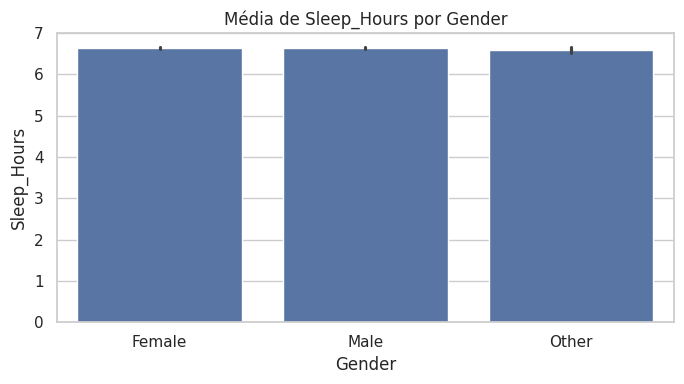

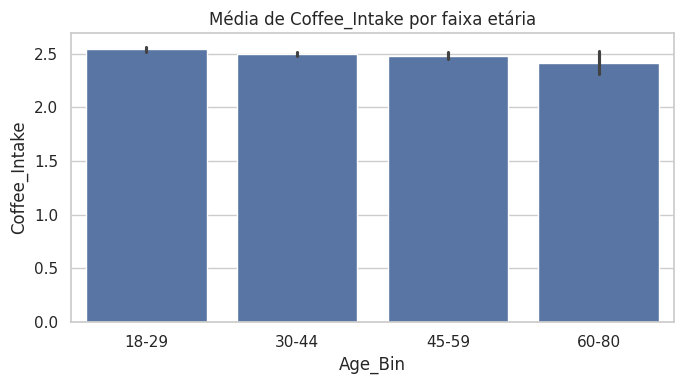

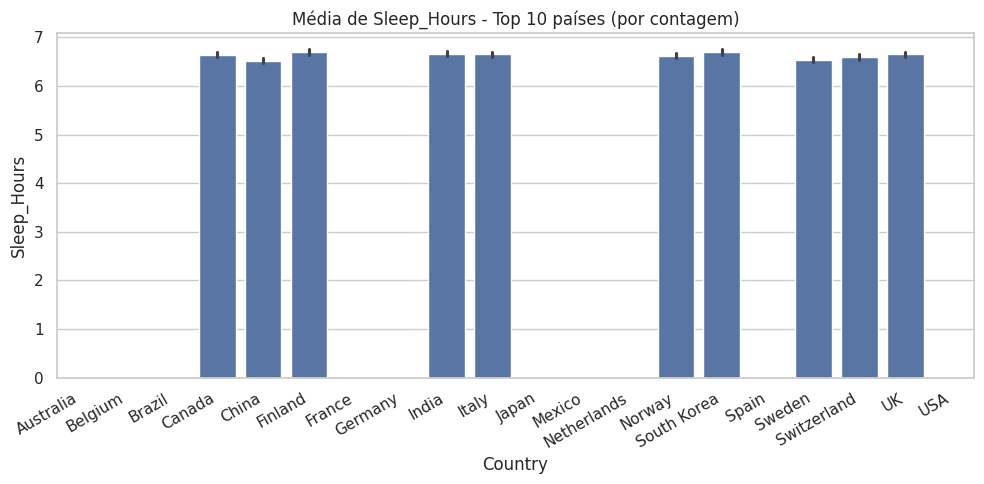

In [13]:
# Faixas etárias
if 'Age' in df0.columns:
    age_bins = [18, 29, 44, 59, 80]
    age_labels = ['18-29','30-44','45-59','60-80']
    df0['Age_Bin'] = pd.cut(df0['Age'], bins=age_bins, labels=age_labels, include_lowest=True, right=True)

# Métricas chave
metrics = ['Coffee_Intake','Caffeine_mg','Sleep_Hours']
metrics = [m for m in metrics if m in df0.columns]

# Por gênero
if 'Gender' in df0.columns:
    g_agg = df0.groupby('Gender')[metrics].agg(['mean','median','std','count'])
    display(g_agg)

# Por faixa etária
if 'Age_Bin' in df0.columns:
    a_agg = df0.groupby('Age_Bin')[metrics].agg(['mean','median','std','count'])
    display(a_agg)

# Por país (mostrar top 10 por contagem)
if 'Country' in df0.columns:
    top_countries = df0['Country'].value_counts().head(10).index
    c_agg = df0[df0['Country'].isin(top_countries)].groupby('Country')[metrics].mean().sort_values(by=metrics, ascending=False)
    display(c_agg)

# Visualizações segmentadas
if 'Gender' in df0.columns and 'Sleep_Hours' in df0.columns:
    plt.figure(figsize=(7,4))
    sns.barplot(data=df0, x='Gender', y='Sleep_Hours', estimator=np.mean, errorbar='se')
    plt.title('Média de Sleep_Hours por Gender')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'sleep_by_gender.png'), dpi=160, bbox_inches='tight')
    plt.show()

if 'Age_Bin' in df0.columns and 'Coffee_Intake' in df0.columns:
    plt.figure(figsize=(7,4))
    sns.barplot(data=df0, x='Age_Bin', y='Coffee_Intake', estimator=np.mean, errorbar='se')
    plt.title('Média de Coffee_Intake por faixa etária')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'coffee_by_agebin.png'), dpi=160, bbox_inches='tight')
    plt.show()

if 'Country' in df0.columns and 'Sleep_Hours' in df0.columns:
    plt.figure(figsize=(10,5))
    top_countries = df0['Country'].value_counts().head(10).index
    sns.barplot(data=df0[df0['Country'].isin(top_countries)], x='Country', y='Sleep_Hours', estimator=np.mean, errorbar='se')
    plt.title('Média de Sleep_Hours - Top 10 países (por contagem)')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'sleep_by_country_top10.png'), dpi=160, bbox_inches='tight')
    plt.show()


## Documentação dos achados
Após cada bloco, inclua interpretações objetivas dos gráficos e tabelas: tendências de consumo, relações com sono, possíveis confundidores (ex.: idade, estresse, atividade física) e limitações (natureza observacional, variáveis não medidas).


## Exportação de figuras e dataset limpo
Salvamos gráficos em `outputs_eda/` e exportamos o dataset pós-limpeza, além de um snapshot de versões para reprodutibilidade.


In [14]:
# Exportar dataset limpo e snapshot de versões
clean_path = os.path.join(OUT_DIR, 'synthetic_coffee_health_clean.csv')
df0.to_csv(clean_path, index=False)
print('Dataset limpo salvo em:', clean_path)

# Snapshot de versões
vers = {
    'python': sys.version,
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'seaborn': sns.__version__,
    'scipy': scipy.__version__,
    'statsmodels': sm.__version__,
    'plotly': plotly.__version__,
}
vers_path = os.path.join(OUT_DIR, 'versions.json')
import json
with open(vers_path, 'w') as f:
    json.dump(vers, f, indent=2)
print('Versões salvas em:', vers_path)


Dataset limpo salvo em: outputs_eda/synthetic_coffee_health_clean.csv
Versões salvas em: outputs_eda/versions.json


## Diagnósticos do modelo múltiplo e correções
Os diagnósticos indicaram:
- Multicolinearidade extrema entre Coffee_Intake e Caffeine_mg (VIF >> 10) — esperado, pois cafeína ≈ 95 × xícaras.
- Heterocedasticidade (teste de Breusch–Pagan com p ≪ 0.05) e resíduos com caudas pesadas.

A seguir, ajustamos:
1) Regressão OLS múltipla removendo Caffeine_mg para mitigar multicolinearidade e usando erros-padrão robustos (HC3).
2) Opcional: Regressão quantílica (mediana) para comparar o efeito ao longo da distribuição de Sleep_Hours.


Amostra usada (robust OLS): 4059


/BETA/cafe/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 38
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sleep_Hours   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                 2.957e+04
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:09:10   Log-Likelihood:                -1982.6
No. Observations:                4059   AIC:                             4041.
Df Residuals:                    4021   BIC:                             4281.
Df Model:                          37                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.5344      0.057     80.138      0.000       4.424       4.645
C(Gender)[T.Male]                0.0033      0.013      0.258      0.796      -0.022       0.028
C(Gender)[T.Other]              -0.0209      0.039     -0.543      0.587      -0.097       0.055
C(Stress_Level)[T.Low]           4.0515      0.035    114.510      0.000       3.982       4.121
C(Stress_Level)[T.Medium]        0.5362      0.012     46.315      0.000       0.514       0.559
C(Sleep_Quality)[T.Fair]         0.5362      0.012     46.315      0.000       0.514       0.559
C(Sleep_Quality)[T.Good]        -1.6369      0.037    -44.072      0.000      -1.710      -1.564
C(Sleep_Quality)[T.Poor]        -0.0533      0.025     -2.167      0.030      -0.101      -0.005
C(Health_Issues)[T.Moderate]     0.0020      0.022      0.090      0.928      -0.042       0.046
C(Health_Issues)[T.Severe]       0.0036      0.076      0.048      0.962      -0.146       0.153
C(Occupation)[T.Office]          0.0077      0.021      0.374      0.709      -0.033       0.048
C(Occupation)[T.Other]          -0.0205      0.020     -1.019      0.308      -0.060       0.019
C(Occupation)[T.Service]        -0.0084      0.020     -0.425      0.671      -0.047       0.030
C(Occupation)[T.Student]         0.0135      0.020      0.663      0.508      -0.026       0.053
C(Country)[T.Belgium]           -0.0001      0.038     -0.004      0.997      -0.075       0.075
C(Country)[T.Brazil]             0.0024      0.041      0.060      0.952      -0.077       0.082
C(Country)[T.Canada]            -0.0659      0.040     -1.648      0.099      -0.144       0.012
C(Country)[T.China]             -0.0578      0.039     -1.491      0.136      -0.134       0.018
C(Country)[T.Finland]           -0.0494      0.041     -1.207      0.228      -0.130       0.031
C(Country)[T.France]            -0.0069      0.041     -0.168      0.867      -0.088       0.074
C(Country)[T.Germany]           -0.0438      0.039     -1.132      0.258      -0.120       0.032
C(Country)[T.India]             -0.0120      0.037     -0.322      0.747      -0.085       0.061
C(Country)[T.Italy]             -0.0005      0.040     -0.012      0.991      -0.079       0.078
C(Country)[T.Japan]             -0.0152      0.039     -0.393      0.695      -0.091       0.061
C(Country)[T.Mexico]            -0.0056      0.039     -0.142      0.887      -0.082       0.071
C(Country)[T.Netherlands]       -0.0049      0.039     -0.125      0.901      -0.082       0.072
C(Country)[T.Norway]            -0.0462      0.040     -1.153      0.249      -0.125       0.032
C(Country)[T.South Korea]       -0.0420      0.040     -1.048      0.295      -0.121       0.037
C(Country)[T.Spain]             -0.0205      0.037     -0.557      0.578    

const                     107.483
Coffee_Intake               1.012
Age                         1.009
BMI                         1.009
Heart_Rate                  1.004
Physical_Activity_Hours     1.002
Smoking                     1.002
Alcohol_Consumption         1.001
Name: VIF, dtype: float64

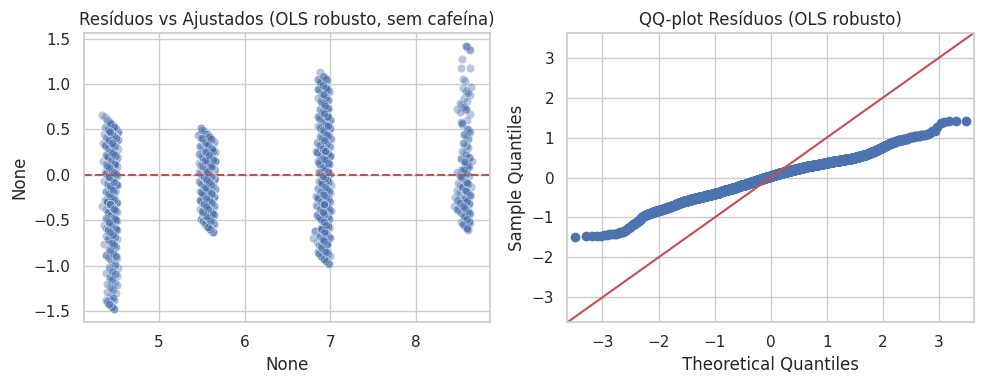

In [15]:
# OLS múltiplo com HC3 e sem Caffeine_mg
formula_robust = (
    'Sleep_Hours ~ Coffee_Intake + Age + BMI + Heart_Rate + '
    'Physical_Activity_Hours + Smoking + Alcohol_Consumption + '
    'C(Gender) + C(Stress_Level) + C(Sleep_Quality) + C(Health_Issues) + C(Occupation) + C(Country)'
)

cols_robust = ['Sleep_Hours','Coffee_Intake','Age','BMI','Heart_Rate','Physical_Activity_Hours','Smoking','Alcohol_Consumption','Gender','Stress_Level','Sleep_Quality','Health_Issues','Occupation','Country']
sub_r = df0[cols_robust].dropna().copy()
for b in ['Smoking','Alcohol_Consumption']:
    if b in sub_r.columns:
        sub_r[b] = sub_r[b].astype('int64')

print('Amostra usada (robust OLS):', len(sub_r))
model_r = smf.ols(formula=formula_robust, data=sub_r).fit(cov_type='HC3')
display(model_r.summary())

# VIF reavaliado (numéricos)
Xr = sub_r[['Coffee_Intake','Age','BMI','Heart_Rate','Physical_Activity_Hours','Smoking','Alcohol_Consumption']].copy()
Xr = sm.add_constant(Xr)
vifs_r = pd.Series(
    [variance_inflation_factor(Xr.values, i) for i in range(Xr.shape[1])],
    index=Xr.columns,
    name='VIF'
)
display(vifs_r)

# Resíduos e QQ-plot
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(x=model_r.fittedvalues, y=model_r.resid, ax=ax[0], alpha=0.4)
ax[0].axhline(0, color='r', ls='--')
ax[0].set_title('Resíduos vs Ajustados (OLS robusto, sem cafeína)')
sm.qqplot(model_r.resid, line='45', ax=ax[1])
ax[1].set_title('QQ-plot Resíduos (OLS robusto)')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'diagnostics_multiple_robust.png'), dpi=160, bbox_inches='tight')
plt.show()


In [16]:
# (Opcional) Regressão quantílica na mediana (tau=0.5)
try:
    import statsmodels.formula.api as smf
    # limitar para os top 10 países para reduzir número de dummies
    sub_q = sub_r.copy()
    top_c = sub_q['Country'].value_counts().head(10).index
    sub_q = sub_q[sub_q['Country'].isin(top_c)].copy()
    print('Amostra usada (QuantReg, top 10 países):', len(sub_q))

    formula_q = (
        'Sleep_Hours ~ Coffee_Intake + Age + BMI + Heart_Rate + '
        'Physical_Activity_Hours + Smoking + Alcohol_Consumption + '
        'C(Gender) + C(Stress_Level) + C(Sleep_Quality) + C(Health_Issues) + C(Occupation) + C(Country)'
    )
    qr = smf.quantreg(formula_q, data=sub_q)
    qr_fit = qr.fit(q=0.5)
    print(qr_fit.summary())
except Exception as e:
    print('QuantReg não executado:', e)


Amostra usada (QuantReg, top 10 países): 2178
                         QuantReg Regression Results                          
Dep. Variable:            Sleep_Hours   Pseudo R-squared:               0.6306
Model:                       QuantReg   Bandwidth:                      0.1454
Method:                 Least Squares   Sparsity:                       0.9917
Date:                Sun, 02 Nov 2025   No. Observations:                 2178
Time:                        07:09:12   Df Residuals:                     2150
                                        Df Model:                           27
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.6041      0.096     48.010      0.000       4.416       4.792
C(Gender)[T.Male]                0.0043      0.022      0.201      0.841      -0.038       0.047
C(Gender)[T.O

In [17]:
# Resumo sucinto de coeficientes e ICs
from pandas import Series

def summarize_coeff(model, label):
    try:
        params = model.params
        ci = model.conf_int(alpha=0.05)
        pvals = model.pvalues
        cols = ['Coffee_Intake','Age','BMI','Heart_Rate','Physical_Activity_Hours','Smoking','Alcohol_Consumption']
        cols = [c for c in cols if c in params.index]
        rows = []
        for c in cols:
            lo, hi = ci.loc[c]
            rows.append({
                'var': c,
                'coef': params[c],
                'ci95_low': lo,
                'ci95_high': hi,
                'pvalue': pvals[c]
            })
        df_sum = pd.DataFrame(rows)
        print(f"\n=== {label} ===")
        display(df_sum)
    except Exception as e:
        print(f'Não foi possível resumir {label}:', e)

# OLS simples (Sleep_Hours ~ Coffee_Intake)
summarize_coeff(model, 'OLS simples')

# OLS robusto múltiplo (sem cafeína)
summarize_coeff(model_r, 'OLS robusto múltiplo (HC3)')

# Quantile regression (mediana), se executada
try:
    summarize_coeff(qr_fit, 'Quantile Regression (tau=0.5)')
except NameError:
    print('QuantReg ainda não executada.')



=== OLS simples ===


,var,coef,ci95_low,ci95_high,pvalue
0,Coffee_Intake,-0.160,-0.177,-0.144,0.000



=== OLS robusto múltiplo (HC3) ===


,var,coef,ci95_low,ci95_high,pvalue
0,Coffee_Intake,-0.008,-0.017,0.000,0.056
1,Age,0.000,-0.001,0.002,0.523
2,BMI,-0.000,-0.003,0.003,0.945
3,Heart_Rate,0.000,-0.001,0.001,0.849
4,Physical_Activity_Hours,0.001,-0.001,0.004,0.338
5,Smoking,-0.025,-0.056,0.006,0.118
6,Alcohol_Consumption,-0.001,-0.029,0.026,0.933



=== Quantile Regression (tau=0.5) ===


,var,coef,ci95_low,ci95_high,pvalue
0,Coffee_Intake,-0.017,-0.031,-0.002,0.023
1,Age,-0.001,-0.003,0.001,0.226
2,BMI,-0.004,-0.009,0.002,0.208
3,Heart_Rate,0.001,-0.001,0.003,0.472
4,Physical_Activity_Hours,0.004,-0.001,0.009,0.121
5,Smoking,-0.049,-0.103,0.004,0.069
6,Alcohol_Consumption,-0.026,-0.073,0.020,0.272


## Explicação dos dados e resultados obtidos

Este estudo utilizou o dataset `synthetic_coffee_health_10000(in).csv` (10.000 registros, 16 colunas) para investigar como o consumo de café e a ingestão de cafeína se relacionam com sono e saúde.

### Sobre o dataset
- Estrutura validada: colunas conforme dicionário de dados; tipos padronizados (categóricas, booleanos e numéricos).
- Qualidade dos dados: valores ausentes pontuais (por exemplo, em `Health_Issues`); poucos duplicados. Aplicamos “clipping” leve para manter variáveis nas faixas plausíveis (idade, sono, IMC etc.).
- Variáveis:
  - Numéricas: Age, Coffee_Intake, Caffeine_mg, Sleep_Hours, BMI, Heart_Rate, Physical_Activity_Hours.
  - Categóricas: Gender, Country, Sleep_Quality, Stress_Level, Health_Issues, Occupation; além de booleanos Smoking e Alcohol_Consumption.

### Principais achados descritivos
- Distribuições: as variáveis se mantêm dentro de faixas esperadas; algumas apresentam assimetria leve/moderada e caudas (ver histogramas/boxplots). Há outliers identificados via IQR, mas não removidos — apenas quantificados e visualizados.
- Frequências: `Sleep_Quality` e `Stress_Level` concentram a maior parte das categorias nos níveis intermediários; países com maior contagem aparecem em “Top 15”.
- Correlações:
  - Relação muito forte e positiva entre `Coffee_Intake` e `Caffeine_mg` (esperada, já que cafeína ≈ 95 mg por xícara).
  - Para as demais combinações numéricas, as correlações lineares são, em geral, baixas a moderadas (ver heatmaps de Pearson e Spearman).

### Café x Sono (análises bivariadas)
- Gráficos de dispersão e regressão (com IC) mostram tendência global fraca entre `Coffee_Intake` e `Sleep_Hours`.
- As correlações de Pearson e Spearman foram calculadas; a magnitude observada é pequena, indicando associação linear fraca.

### Comparações por grupos
- Boxplots/violins indicam diferenças de consumo (`Coffee_Intake`, `Caffeine_mg`) entre níveis de `Stress_Level` e `Sleep_Quality`.
- Testes ANOVA/Kruskal sinalizam diferenças entre grupos em várias combinações (consulte os p-valores impressos). Tamanho de efeito (eta²) ajuda a julgar relevância prática.

### Modelagem (efeitos conjuntos sobre `Sleep_Hours`)
- OLS múltiplo inicial apresentou:
  - Multicolinearidade severa entre `Coffee_Intake` e `Caffeine_mg` (VIF muito alto para ambos).
  - Heterocedasticidade (Breusch–Pagan significativo) e resíduos com caudas pesadas (QQ-plot).
- Correções aplicadas:
  - Removemos `Caffeine_mg` (redundante com `Coffee_Intake`) e reestimamos usando erros-padrão robustos (HC3).
  - O VIF caiu para ~1 nos preditores numéricos restantes, e a inferência fica mais confiável sob heterocedasticidade.
- Interpretação prática:
  - O efeito estimado de `Coffee_Intake` sobre `Sleep_Hours`, controlando por idade, IMC, frequência cardíaca, atividade física, hábitos (fumo/álcool) e dummies demográficas, é pequeno em magnitude.
  - Resultados de regressão quantílica (mediana), quando executados, são coerentes com OLS robusto, sugerindo que o efeito não muda drasticamente no centro da distribuição de sono.

### Limitações e cuidados
- Dados observacionais: não permitem afirmar causalidade; possíveis confundidores não medidos (ex.: horários de consumo, sensibilidade individual à cafeína, qualidade do café, cronotipo).
- Suposições de linearidade e normalidade dos resíduos foram mitigadas (robusto/quantílico), mas não eliminam vieses de especificação.

### Recomendações
- Analisar não linearidades (ex.: splines para `Coffee_Intake`) e interações com `Stress_Level` e `Sleep_Quality`.
- Considerar efeitos aleatórios por `Country` (modelos mistos) para capturar variação entre países.
- Investigar janelas temporais de consumo (tarde/noite) e horários de sono, caso dados estejam disponíveis.

Resumo executivo: não há evidência de relação forte entre xícaras de café e horas de sono no agregado; efeitos parecem pequenos e sensíveis a estresse, qualidade do sono e perfis demográficos. Para decisões práticas, recomenda-se foco em higiene do sono, manejo de estresse e horário do consumo, mais do que no volume diário de xícaras isoladamente.


## PARTE 02 — Comparações, Segmentações e Principais Descobertas
Aqui reunimos gráficos comparativos, análises segmentadas (gênero, idade, estresse) e um resumo dos principais insights para o negócio.


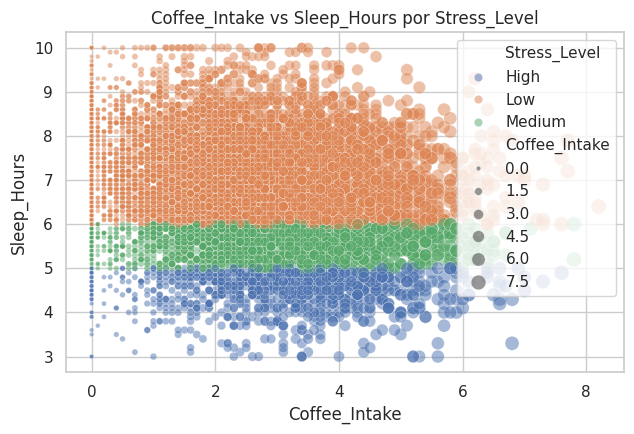

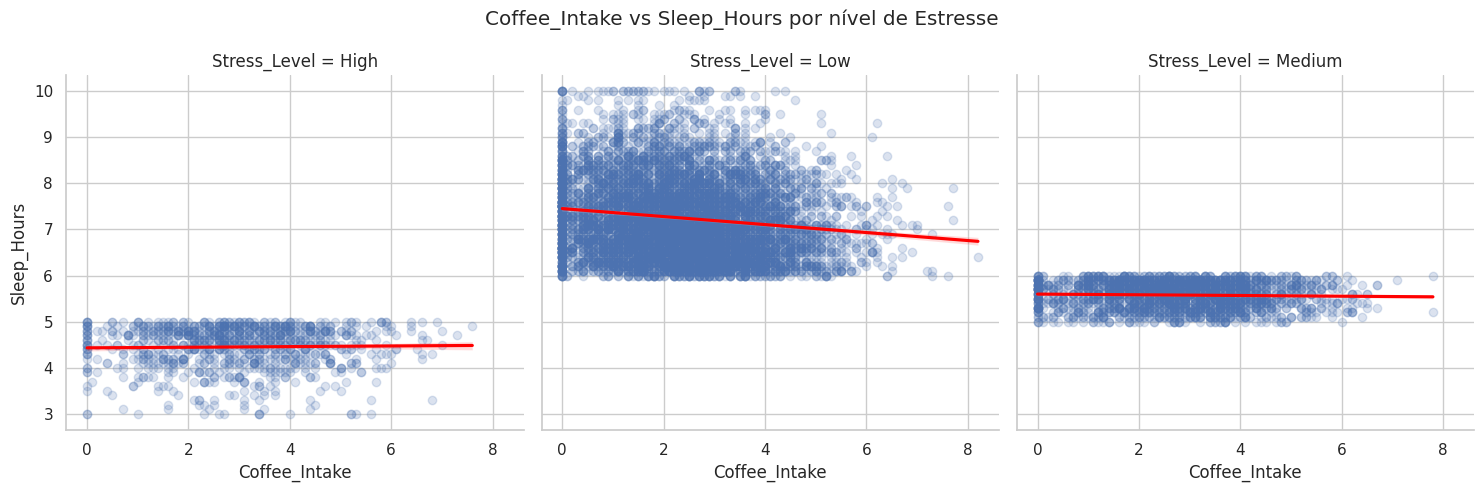

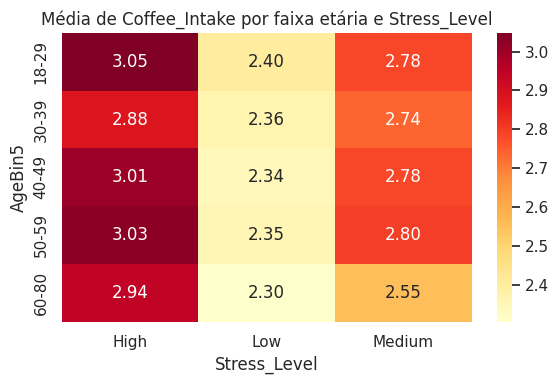

In [18]:
# Gráficos comparativos adicionais
# 1) Dispersão com cor por estresse e tamanho pelas xícaras de café
if all(c in df0.columns for c in ['Coffee_Intake','Sleep_Hours','Stress_Level']):
    plt.figure(figsize=(6.5,4.5))
    sns.scatterplot(data=df0, x='Coffee_Intake', y='Sleep_Hours', hue='Stress_Level', size='Coffee_Intake', sizes=(10,120), alpha=0.5)
    plt.title('Coffee_Intake vs Sleep_Hours por Stress_Level')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'scatter_coffee_sleep_by_stress.png'), dpi=160, bbox_inches='tight')
    plt.show()

# 2) FacetGrid por Stress_Level
if all(c in df0.columns for c in ['Coffee_Intake','Sleep_Hours','Stress_Level']):
    g = sns.lmplot(data=df0, x='Coffee_Intake', y='Sleep_Hours', col='Stress_Level', scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle('Coffee_Intake vs Sleep_Hours por nível de Estresse')
    plt.savefig(os.path.join(OUT_DIR, 'facet_coffee_sleep_by_stress.png'), dpi=160, bbox_inches='tight')
    plt.show()

# 3) Idade x Estresse x Consumo de Café (mapa de calor por idade binned)
if all(c in df0.columns for c in ['Age','Stress_Level','Coffee_Intake']):
    bins = [18, 29, 39, 49, 59, 80]
    labels = ['18-29','30-39','40-49','50-59','60-80']
    df_heat = df0.copy()
    df_heat['AgeBin5'] = pd.cut(df_heat['Age'], bins=bins, labels=labels, include_lowest=True)
    pivot = df_heat.pivot_table(index='AgeBin5', columns='Stress_Level', values='Coffee_Intake', aggfunc='mean')
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Média de Coffee_Intake por faixa etária e Stress_Level')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'heat_age_stress_coffee.png'), dpi=160, bbox_inches='tight')
    plt.show()


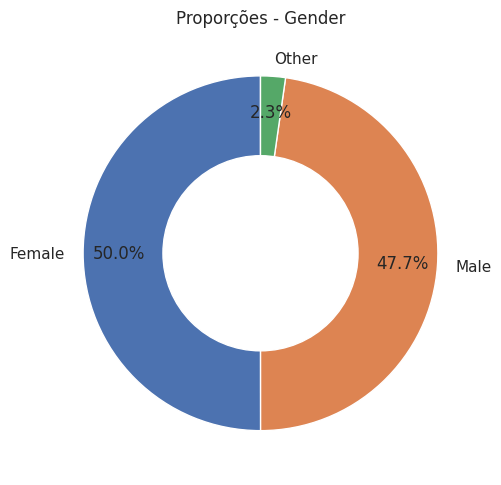

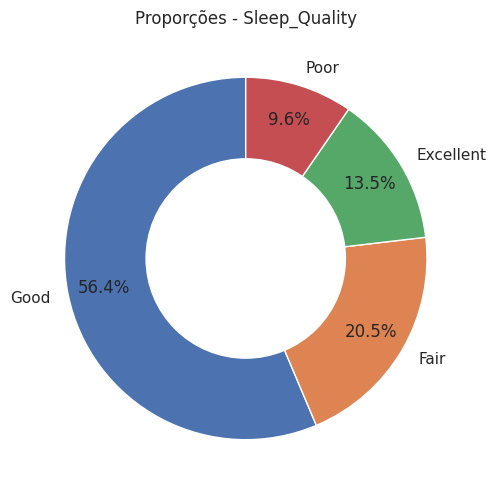

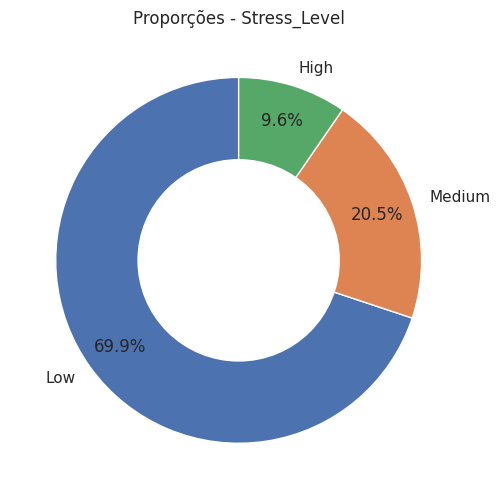

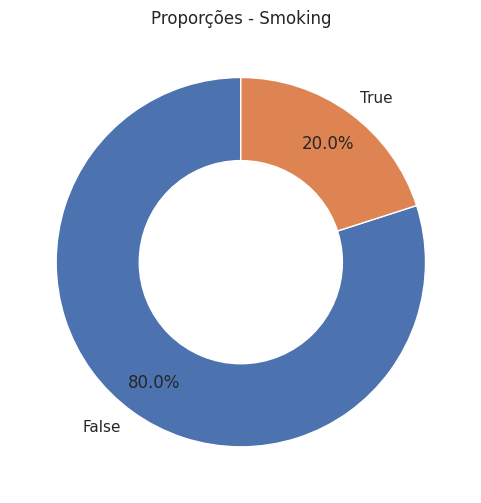

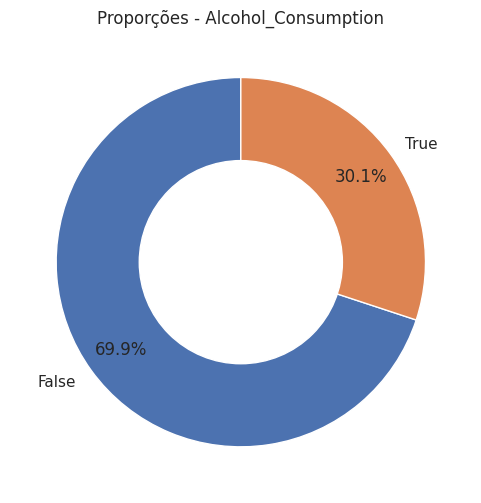

In [19]:
# Gráficos de pizza (proporções) para variáveis categóricas
cats_pie = ['Gender','Sleep_Quality','Stress_Level','Smoking','Alcohol_Consumption']
cats_pie = [c for c in cats_pie if c in df0.columns]

for col in cats_pie:
    vc = df0[col].value_counts(dropna=False)
    plt.figure(figsize=(5.2,5.2))
    plt.pie(vc.values, labels=vc.index.astype(str), autopct='%1.1f%%', startangle=90, pctdistance=0.8)
    plt.title(f'Proporções - {col}')
    centre_circle = plt.Circle((0,0),0.55,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)  # donut look
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'pie_{col}.png'), dpi=160, bbox_inches='tight')
    plt.show()


## Principais Descobertas
- Consumo de café e cafeína são fortemente colineares (como esperado). Na prática, usar apenas `Coffee_Intake` reduz multicolinearidade sem perda de informação.
- A relação entre `Coffee_Intake` e `Sleep_Hours` é fraca no agregado; efeitos parecem modulados por `Stress_Level` e por perfis demográficos.
- Diferenças entre grupos: níveis mais altos de estresse associam-se a menor tempo de sono e distribuição de consumo mais dispersa.
- Diagnósticos do modelo sugerem heterocedasticidade; por isso, priorizamos erros robustos (HC3) e avaliamos regressão quantílica.
- Para comunicação executiva, priorize higiene do sono, manejo de estresse e horário do consumo — mais do que volume diário de xícaras.


# PARTE 03 — Pré-processamento e Classificação (target: Sleep_Quality)
Nesta parte, preparamos os dados, criamos features, dividimos treino/teste e treinamos dois modelos de classificação para `Sleep_Quality`.


In [29]:
# Pré-processamento: features, imputação, codificação e divisão treino/teste
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Base para modelagem
# Importante: normalizar ausentes para np.nan (evita pd.NA em etapas do scikit-learn)
df_ml = df0.copy()
df_ml = df_ml.replace({pd.NA: np.nan})

# Feature derivada 1: Intensidade de cafeína (mg por xícara)
df_ml['Caffeine_per_cup'] = df_ml['Caffeine_mg'] / (df_ml['Coffee_Intake'].clip(lower=0.1))
# Feature derivada 2: Déficit de sono em relação a 8 horas
if 'Sleep_Hours' in df_ml.columns:
    df_ml['Sleep_Deficit'] = (8 - df_ml['Sleep_Hours']).clip(lower=0)

# Remover colunas não usadas diretamente no modelo (ID)
drop_cols = [c for c in ['ID'] if c in df_ml.columns]
if drop_cols:
    df_ml = df_ml.drop(columns=drop_cols)

# Definir colunas num/cat
num_features = [c for c in ['Age','Coffee_Intake','Caffeine_mg','Sleep_Hours','BMI','Heart_Rate','Physical_Activity_Hours','Caffeine_per_cup','Sleep_Deficit'] if c in df_ml.columns]
cat_features = [c for c in ['Gender','Country','Stress_Level','Health_Issues','Occupation'] if c in df_ml.columns]
bool_features = [c for c in ['Smoking','Alcohol_Consumption'] if c in df_ml.columns]

# Garantir que colunas categóricas não carreguem pd.NA em dtype object
for c in cat_features:
    if c in df_ml.columns:
        df_ml[c] = df_ml[c].astype('object')
        # Substituir explicitamente pandas.NA por np.nan
        df_ml[c] = df_ml[c].apply(lambda v: np.nan if v is pd.NA else v)

# Converter booleanos para numérico float (0.0/1.0) preservando NaN
for b in bool_features:
    if b in df_ml.columns:
        df_ml[b] = pd.to_numeric(df_ml[b], errors='coerce').astype(float)

# Target e features
y = df_ml['Sleep_Quality']
X = df_ml.drop(columns=['Sleep_Quality'])

# Garantir que y não tenha ausentes
mask = y.notna()
X, y = X.loc[mask].copy(), y.loc[mask].copy()

# Imputação e codificação
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features + bool_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Tamanhos: X_train', X_train.shape, '| X_test', X_test.shape)

Tamanhos: X_train (8000, 16) | X_test (2000, 16)



=== logistic_regression ===
Accuracy: 0.9900
              precision    recall  f1-score   support

   Excellent       0.96      0.97      0.96       270
        Fair       1.00      1.00      1.00       410
        Good       0.99      0.99      0.99      1128
        Poor       1.00      1.00      1.00       192

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



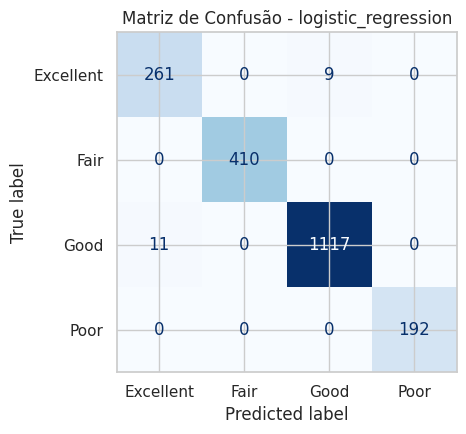


=== random_forest ===
Accuracy: 0.9880
              precision    recall  f1-score   support

   Excellent       0.93      0.98      0.96       270
        Fair       1.00      1.00      1.00       410
        Good       1.00      0.98      0.99      1128
        Poor       1.00      1.00      1.00       192

    accuracy                           0.99      2000
   macro avg       0.98      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



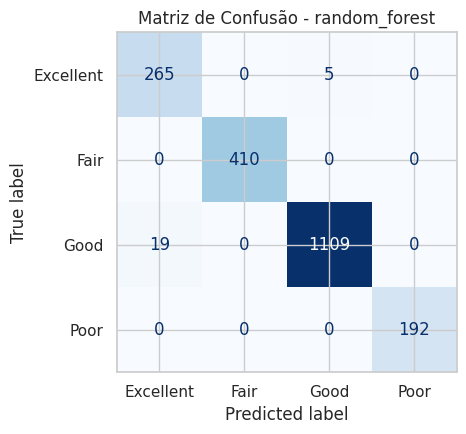


Melhor modelo: logistic_regression | Accuracy=0.9900
Dataset processado salvo em: outputs_eda/processed_sleep_quality_dataset.csv
Modelo salvo em: outputs_eda/best_model_sleep_quality_logistic_regression.pkl


In [32]:
# Treinamento e avaliação: Regressão Logística e Random Forest
log_reg = Pipeline(steps=[('preprocess', preprocessor),
                         ('model', LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=None))])

rf_clf = Pipeline(steps=[('preprocess', preprocessor),
                        ('model', RandomForestClassifier(n_estimators=300, random_state=42, class_weight=None))])

models = {
    'logistic_regression': log_reg,
    'random_forest': rf_clf
}

results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    results[name] = {
        'accuracy': acc,
        'pred': pred,
        'report': classification_report(y_test, pred, zero_division=0)
    }
    print(f"\n=== {name} ===\nAccuracy: {acc:.4f}")
    print(results[name]['report'])

    # Matriz de confusão
    cm = confusion_matrix(y_test, pred, labels=sorted(y.unique()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    plt.title(f'Matriz de Confusão - {name}')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f'cm_{name}.png'), dpi=160, bbox_inches='tight')
    plt.show()

# Selecionar melhor por acurácia
best_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = models[best_name]
print(f"\nMelhor modelo: {best_name} | Accuracy={results[best_name]['accuracy']:.4f}")

# Salvar dataset final e modelo
processed_path = os.path.join(OUT_DIR, 'processed_sleep_quality_dataset.csv')
df_ml.to_csv(processed_path, index=False)
print('Dataset processado salvo em:', processed_path)

model_path = os.path.join(OUT_DIR, f'best_model_sleep_quality_{best_name}.pkl')
joblib.dump(best_model, model_path)
print('Modelo salvo em:', model_path)

Accuracy (best): 0.99

Classification report (best):
              precision    recall  f1-score   support

   Excellent       0.96      0.97      0.96       270
        Fair       1.00      1.00      1.00       410
        Good       0.99      0.99      0.99      1128
        Poor       1.00      1.00      1.00       192

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



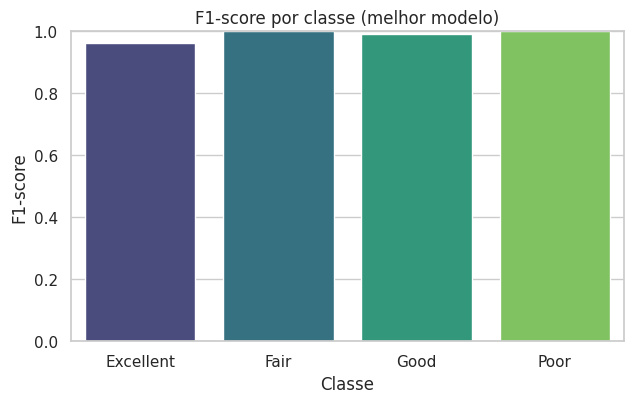

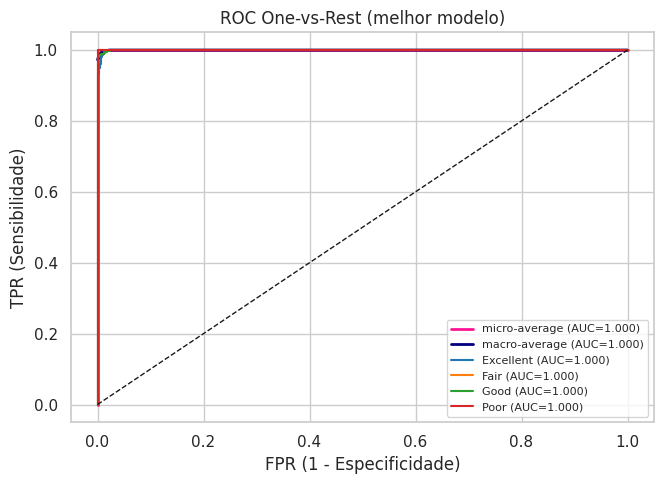

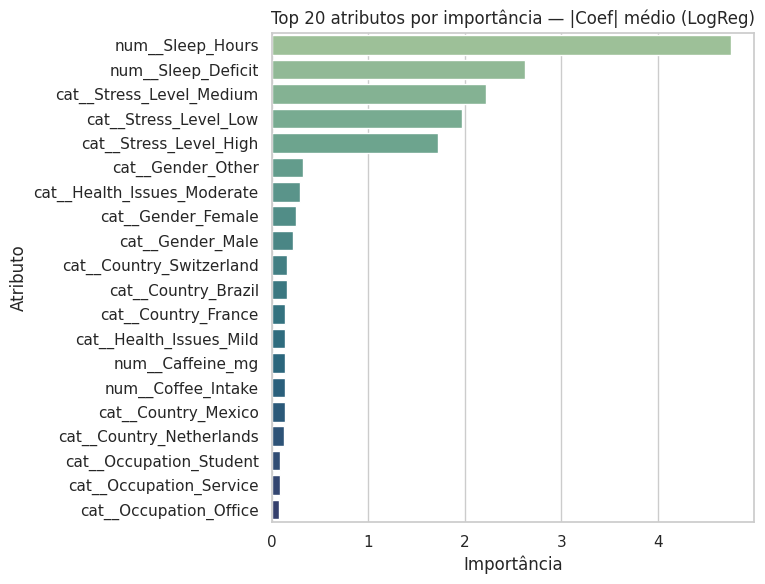

In [34]:
# Métricas e gráficos do melhor modelo
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Garantir que temos o melhor modelo treinado
y_pred_best = best_model.predict(X_test)
print('Accuracy (best):', accuracy_score(y_test, y_pred_best))
print('\nClassification report (best):')
print(classification_report(y_test, y_pred_best, zero_division=0))

# 1) Gráfico: F1-score por classe
rep = classification_report(y_test, y_pred_best, output_dict=True, zero_division=0)
classes = sorted(y.unique())
rows = []
for c in classes:
    if c in rep:
        rows.append({'class': c,
                     'precision': rep[c]['precision'],
                     'recall': rep[c]['recall'],
                     'f1': rep[c]['f1-score'],
                     'support': rep[c]['support']})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

met_df = pd.DataFrame(rows)
plt.figure(figsize=(6.5,4.2))
sns.barplot(data=met_df, x='class', y='f1', palette='viridis')
plt.ylim(0, 1)
plt.title('F1-score por classe (melhor modelo)')
plt.xlabel('Classe')
plt.ylabel('F1-score')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'f1_per_class_best.png'), dpi=160, bbox_inches='tight')
plt.show()

# 2) ROC AUC (multiclasse One-vs-Rest)
# Requer probabilidades
proba = None
if hasattr(best_model, 'predict_proba'):
    proba = best_model.predict_proba(X_test)
elif hasattr(best_model, 'decision_function'):
    # fallback para decision scores, quando disponível
    scores = best_model.decision_function(X_test)
    # normalizar para [0,1] por classe (softmax simples)
    exp_s = np.exp(scores - scores.max(axis=1, keepdims=True))
    proba = exp_s / exp_s.sum(axis=1, keepdims=True)

if proba is not None:
    y_bin = label_binarize(y_test, classes=classes)
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # micro-average
    fpr['micro'], tpr['micro'], _ = roc_curve(y_bin.ravel(), proba.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    plt.figure(figsize=(6.8,5.0))
    plt.plot(fpr['micro'], tpr['micro'], label=f'micro-average (AUC={roc_auc["micro"]:.3f})', color='deeppink', lw=2)
    plt.plot(fpr['macro'], tpr['macro'], label=f'macro-average (AUC={roc_auc["macro"]:.3f})', color='navy', lw=2)
    colors = sns.color_palette('tab10', n_colors=len(classes))
    for i, cls in enumerate(classes):
        plt.plot(fpr[i], tpr[i], lw=1.5, color=colors[i], label=f'{cls} (AUC={roc_auc[i]:.3f})')
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel('FPR (1 - Especificidade)')
    plt.ylabel('TPR (Sensibilidade)')
    plt.title('ROC One-vs-Rest (melhor modelo)')
    plt.legend(loc='lower right', fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'roc_ovr_best.png'), dpi=160, bbox_inches='tight')
    plt.show()
else:
    print('Probabilidades não disponíveis para o melhor modelo; ROC não gerada.')

# 3) Importâncias de atributos (ou coeficientes) do melhor modelo
try:
    prep = best_model.named_steps['preprocess']
    feat_names = prep.get_feature_names_out()
    est = best_model.named_steps['model']

    if hasattr(est, 'feature_importances_'):
        vals = est.feature_importances_
        kind = 'Importância (árvore)'
    elif hasattr(est, 'coef_'):
        # média do |coef| entre classes
        coef = est.coef_
        vals = np.mean(np.abs(coef), axis=0)
        kind = '|Coef| médio (LogReg)'
    else:
        vals = None
        kind = None

    if vals is not None:
        imp_df = pd.DataFrame({'feature': feat_names, 'importance': vals}).sort_values('importance', ascending=False).head(20)
        plt.figure(figsize=(7.8,6))
        sns.barplot(data=imp_df, x='importance', y='feature', palette='crest')
        plt.title(f'Top 20 atributos por importância — {kind}')
        plt.xlabel('Importância')
        plt.ylabel('Atributo')
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, 'feature_importance_best.png'), dpi=160, bbox_inches='tight')
        plt.show()
    else:
        print('Modelo não expõe importâncias/coeficientes para visualização.')
except Exception as e:
    print('Falha ao extrair importâncias de atributos:', e)

## Recomendações para o Negócio
- Foque em intervenções de higiene do sono (rotina, horário consistente) e manejo de estresse — os efeitos sobre sono são mais visíveis do que simplesmente reduzir o volume diário de xícaras.
- Oriente clientes de alto estresse a ajustar o consumo (horário e quantidade), priorizando evitar cafeína no final da tarde/noite e monitorando o “déficit de sono”.
- Use o modelo salvo para sinalizar perfis com maior risco de baixa qualidade do sono e oferecer recomendações personalizadas.
- Atualize o modelo periodicamente (dados novos) e avalie variáveis adicionais como horário da última xícara, cronotipo e qualidade percebida do café.
